In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [6]:
import numpy as np
from events_data import EventsData
from dataset import SCDatasetInfo

def plot_sr_stats(events, sr_stats, ax, label, **plot_kwargs):
    assert len(events) == len(sr_stats)

    sr_stats_argsort = np.argsort(sr_stats)[::-1]
    weights = events.weights[sr_stats_argsort]
    is_signal = events.is_signal[sr_stats_argsort]
    is_4b = events.is_4b[sr_stats_argsort]

    ax.plot(
        np.cumsum(weights * is_4b) / np.sum(weights * is_4b),
        np.cumsum(weights * is_signal) / np.sum(weights * is_signal),           
        label=label,
        **plot_kwargs,
    )

def get_is_signal(scdinfo: SCDatasetInfo, signal_filename: str):
    # Now show the answer
    is_signals = []
    for file, file_len in zip(scdinfo.files, scdinfo.get_file_lengths()):
        is_signals.append(
            np.full(file_len, True)
            if file.name == signal_filename
            else np.full(file_len, False)
        )
    is_signal = np.concatenate(is_signals)
    return is_signal



def events_from_scdinfo(scdinfo: SCDatasetInfo, features: list, signal_filename: str) -> EventsData:
    df = scdinfo.fetch_data()
    df["signal"] = get_is_signal(scdinfo, signal_filename)
    events = EventsData.from_dataframe(df, features)

    return events

def hist_events_by_labels(events: EventsData, values: np.ndarray, bins, ax, **hist_kwargs):
    assert len(values) == len(events)   
    ax.hist(values[events.is_3b], 
                        bins=bins, histtype="step", label="3b", 
                        weights=events.weights[events.is_3b], 
                        **hist_kwargs)
    ax.hist(values[events.is_bg4b], 
                bins=bins, histtype="step", label="bg4b", 
                weights=events.weights[events.is_bg4b], 
                **hist_kwargs)
    ax.hist(values[events.is_signal], 
                bins=bins, histtype="step", label="signal", 
                weights=events.weights[events.is_signal], 
                **hist_kwargs)
    
    
def get_histogram_info(events_original: EventsData, values, bins, reweights):
    assert len(events_original) == len(values)

    if isinstance(bins, int):
        # calculate quantiles
        q = np.linspace(0, 1, bins + 1)
        bins = np.quantile(values, q)
        
    events_clone = events_original.clone()
    weights_rw = np.where(events_clone.is_4b, 1, reweights) * events_clone.weights
    weights_rw_sq = np.where(events_clone.is_4b, 1, reweights**2) * events_clone.weights
    
    hist_3b, _ = np.histogram(values[events_original.is_3b], bins=bins, 
                              weights=weights_rw[events_original.is_3b])
    hist_bg4b, _ = np.histogram(values[events_original.is_bg4b], bins=bins, 
                                weights=weights_rw[events_original.is_bg4b])
    hist_signal, _ = np.histogram(values[events_original.is_signal], bins=bins, 
                                  weights=weights_rw[events_original.is_signal])
    hist_4b, _ = np.histogram(values[events_original.is_4b], bins=bins, 
                              weights=weights_rw[events_original.is_4b])
    hist_3b_sq, _ = np.histogram(values[events_original.is_3b], bins=bins,
                                    weights=weights_rw_sq[events_original.is_3b])

    # std_est = np.sqrt((hist_3b + hist_4b) / 2)
    # is_sampled = std_est > 0
    
    std_est = np.sqrt(hist_4b + hist_3b_sq)
    is_sampled = std_est > 0
    sigma = (hist_4b - hist_3b)[is_sampled]  / std_est[is_sampled]
    sigma_avg = np.sqrt(np.mean(sigma**2))
    sigma_bg4b = (hist_bg4b - hist_3b)[is_sampled] / std_est[is_sampled]
    sigma_avg_bg4b = np.sqrt(np.mean(sigma_bg4b**2))
    df = np.sum(is_sampled)

    return {
        "hist_3b": hist_3b,
        "hist_bg4b": hist_bg4b,
        "hist_signal": hist_signal,
        "hist_4b": hist_4b,
        "std_est": std_est,
        "sigma": sigma,
        "sigma_avg": sigma_avg,
        "sigma_bg4b": sigma_bg4b,
        "sigma_avg_bg4b": sigma_avg_bg4b,
        "df": df,
    }

In [4]:
import torch
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
import yaml
import matplotlib.pyplot as plt

config_filename = "configs/counting_test_high_4b_in_CR.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
ratio_4b = config["ratio_4b"]

hashes, hparams = TSTInfo.find({
    "experiment_name": experiment_name,
    "n_3b": n_3b,
    "ratio_4b": ratio_4b,
}, return_hparams=True)

seeds = np.unique([hp["seed"] for hp in hparams])
signal_ratios = np.unique([hp["signal_ratio"] for hp in hparams])
n_3bs = np.unique([hp["n_3b"] for hp in hparams])

tst_results = []
result_size = 0

1528it [00:03, 504.68it/s]


0it [00:00, ?it/s]

1530it [00:01, 1188.92it/s]
  0%|          | 0/7 [00:00<?, ?it/s]

************************
seed:  0 signal_ratio:  0.0 rw_method:  CR


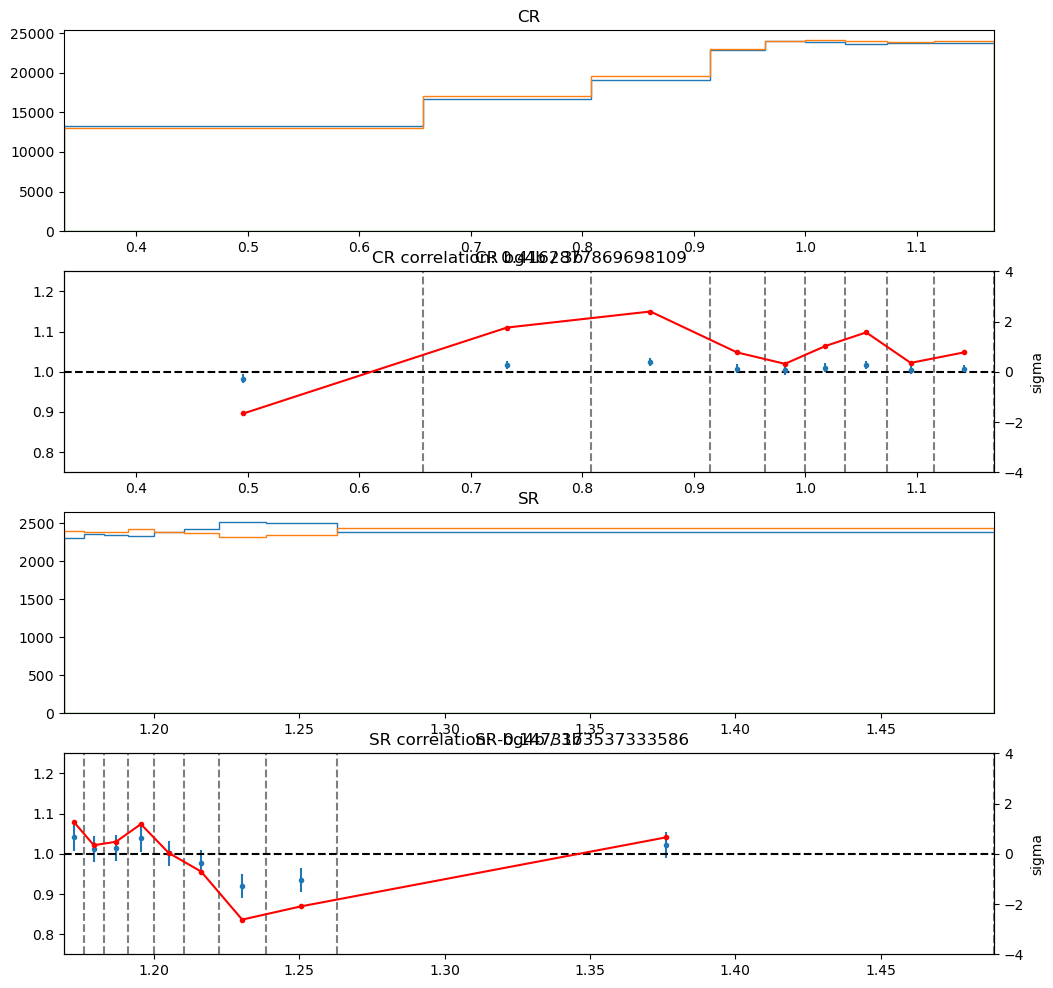

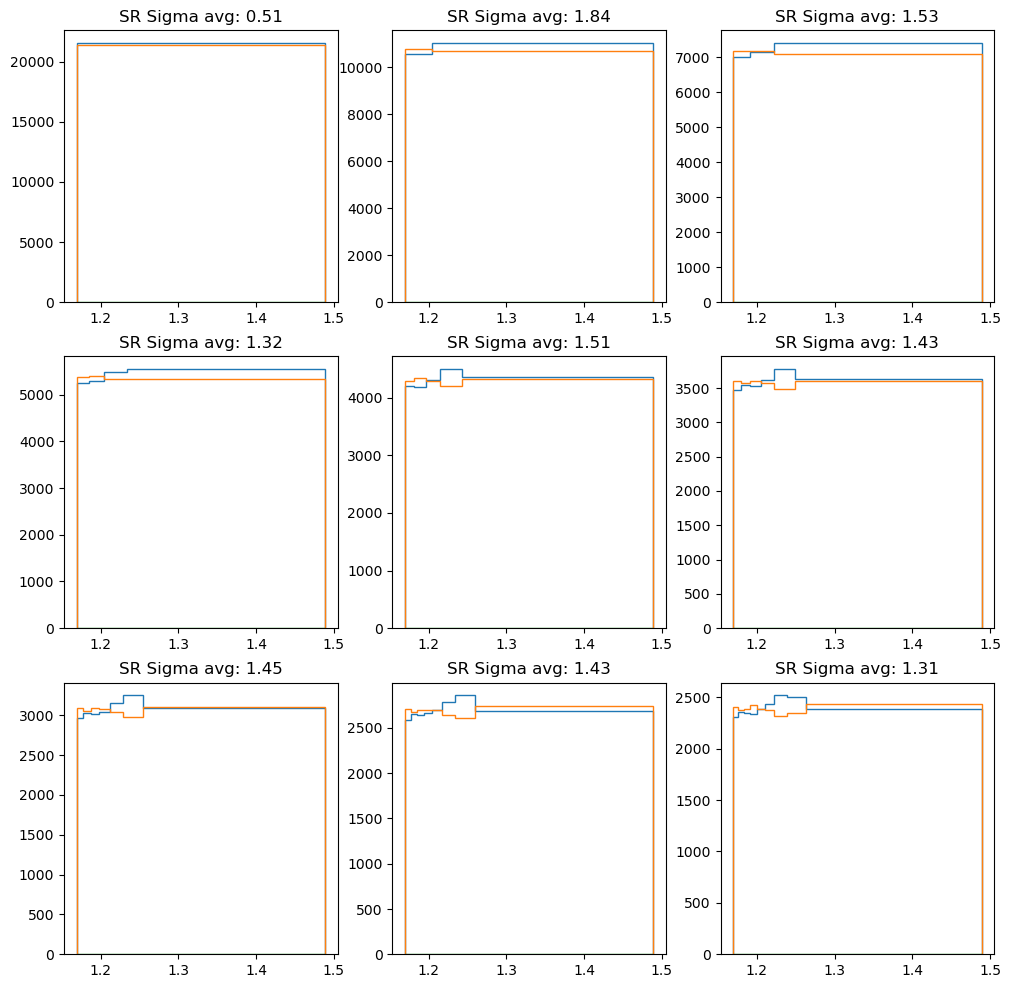

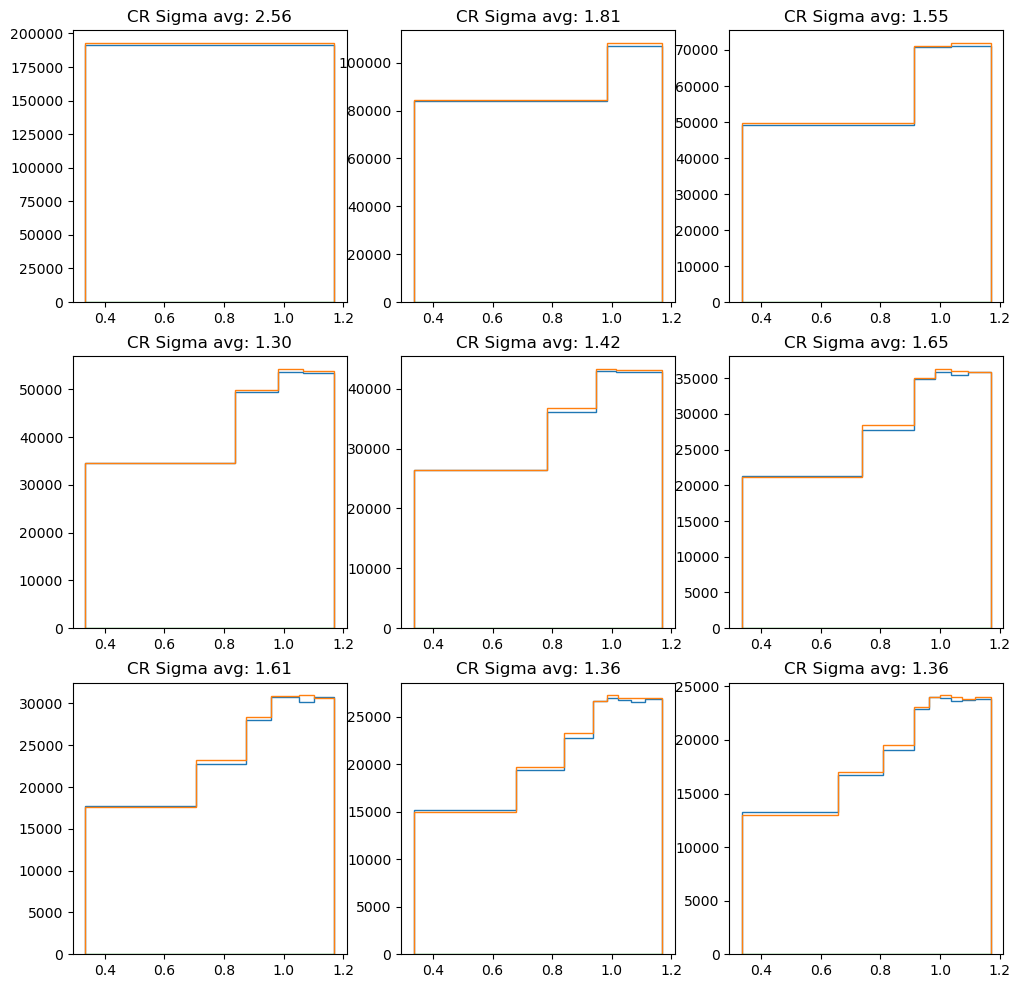

************************
seed:  0 signal_ratio:  0.0 rw_method:  base


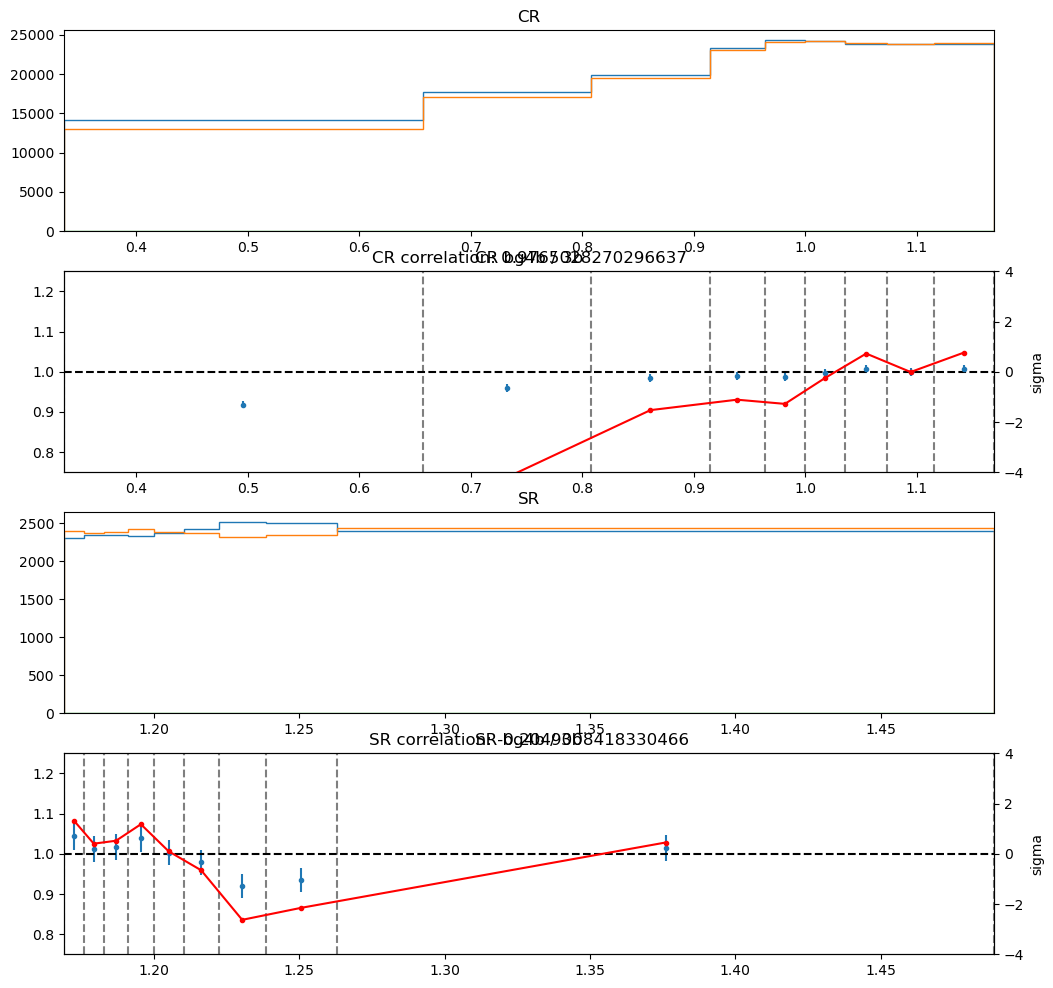

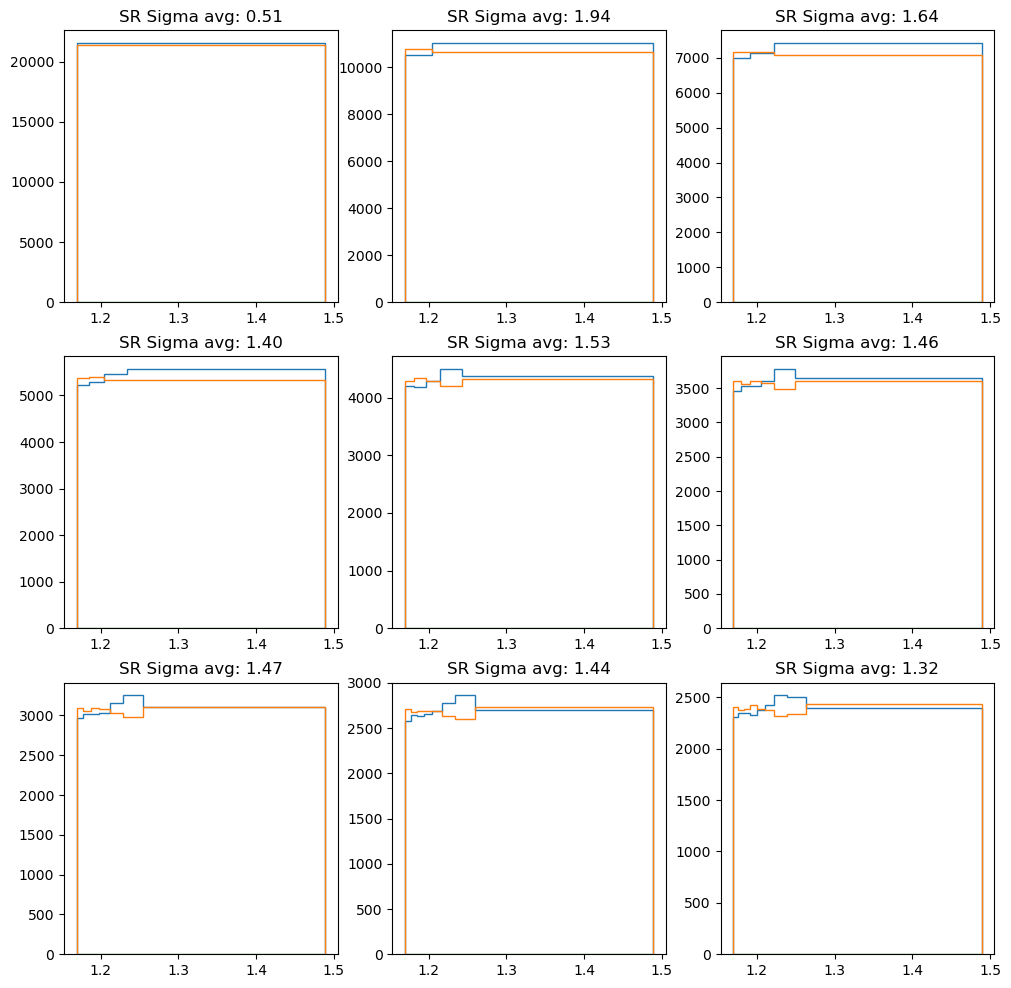

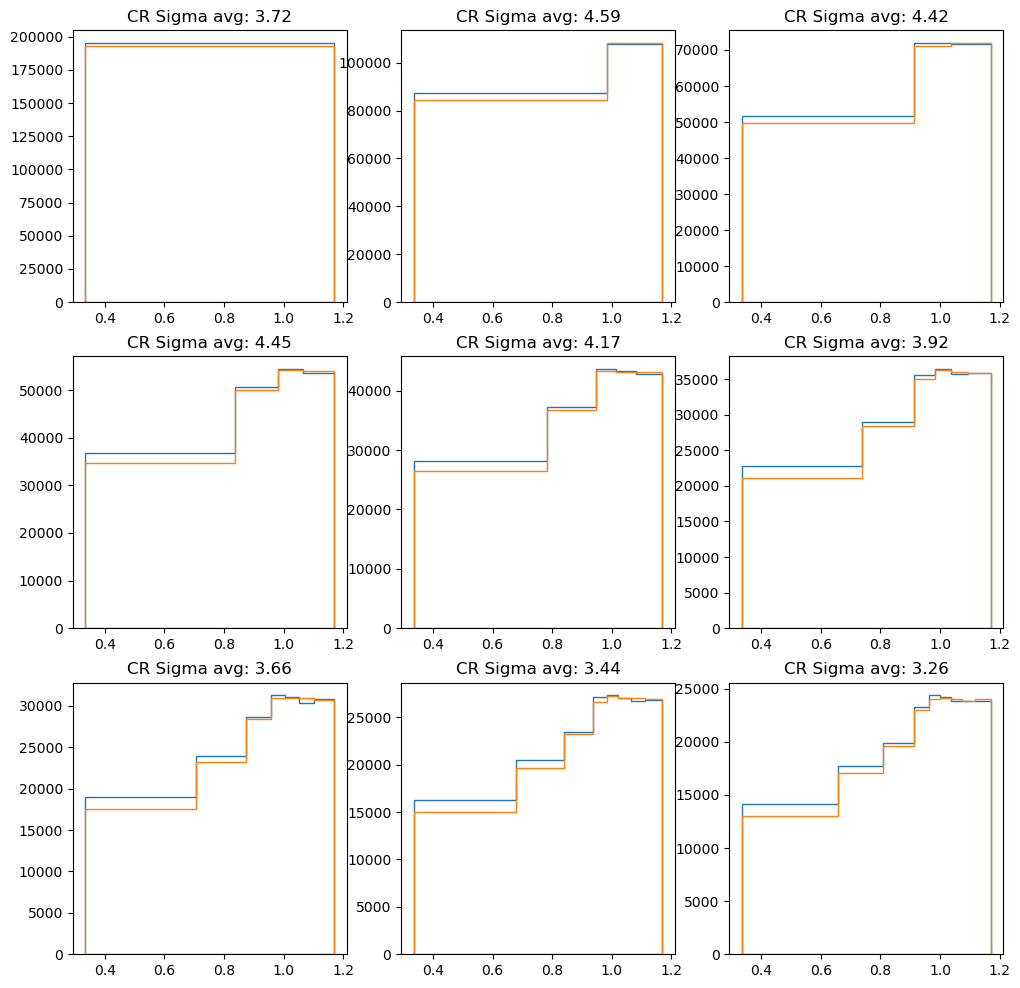

 14%|█▍        | 1/7 [00:25<02:33, 25.61s/it]

************************
seed:  0 signal_ratio:  0.01 rw_method:  CR


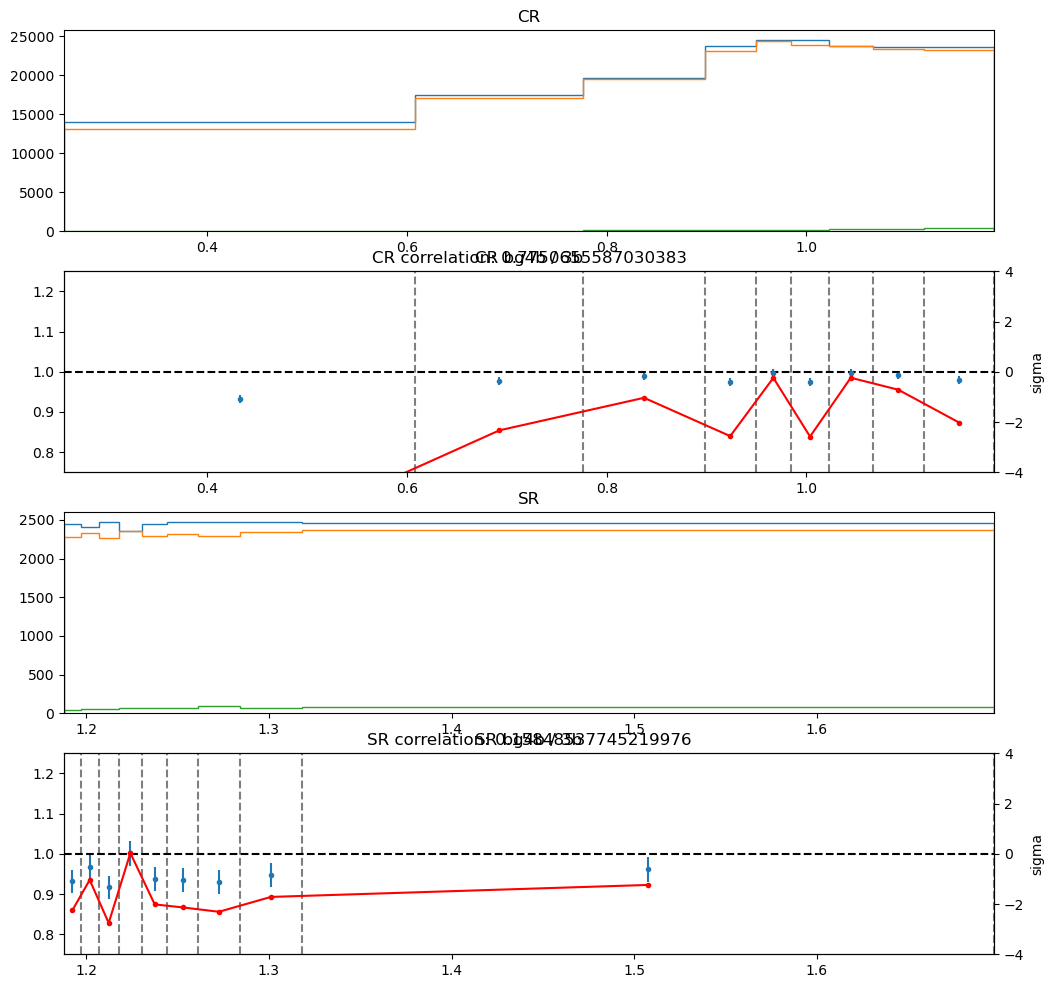

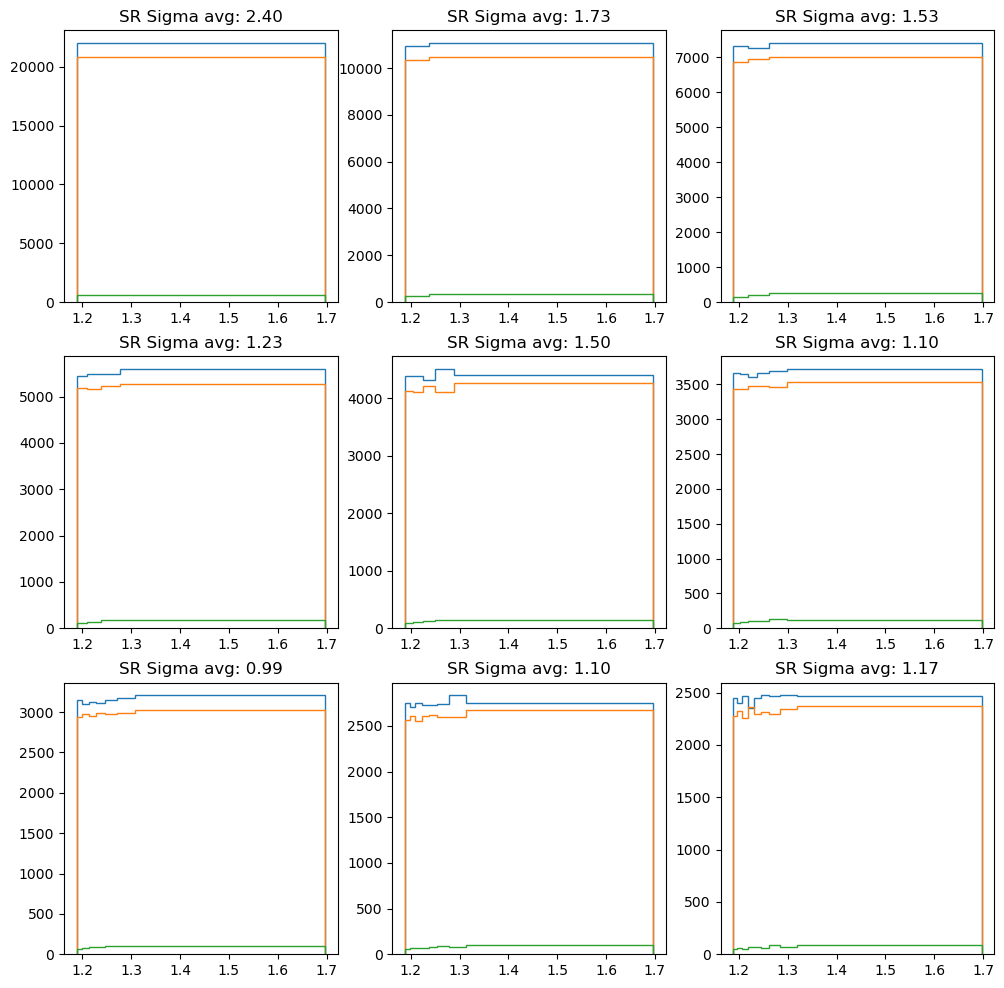

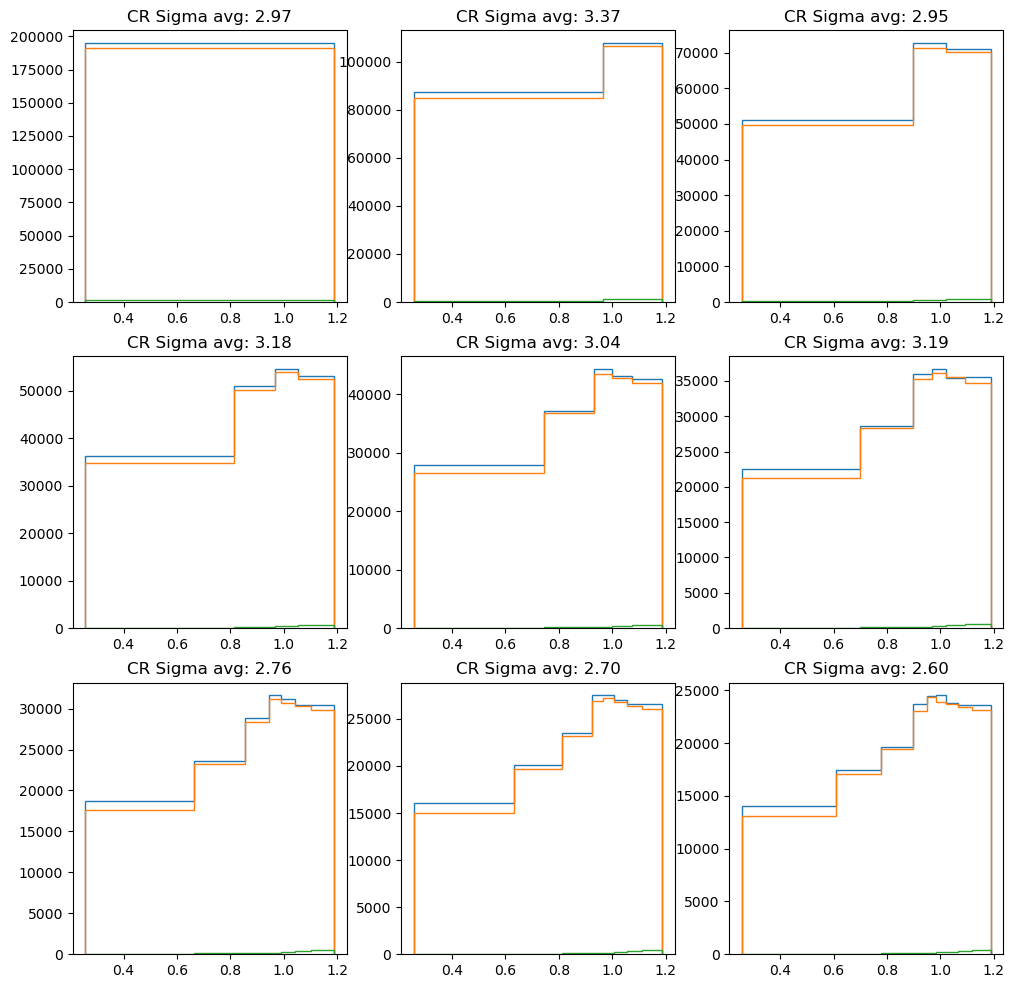

************************
seed:  0 signal_ratio:  0.01 rw_method:  base


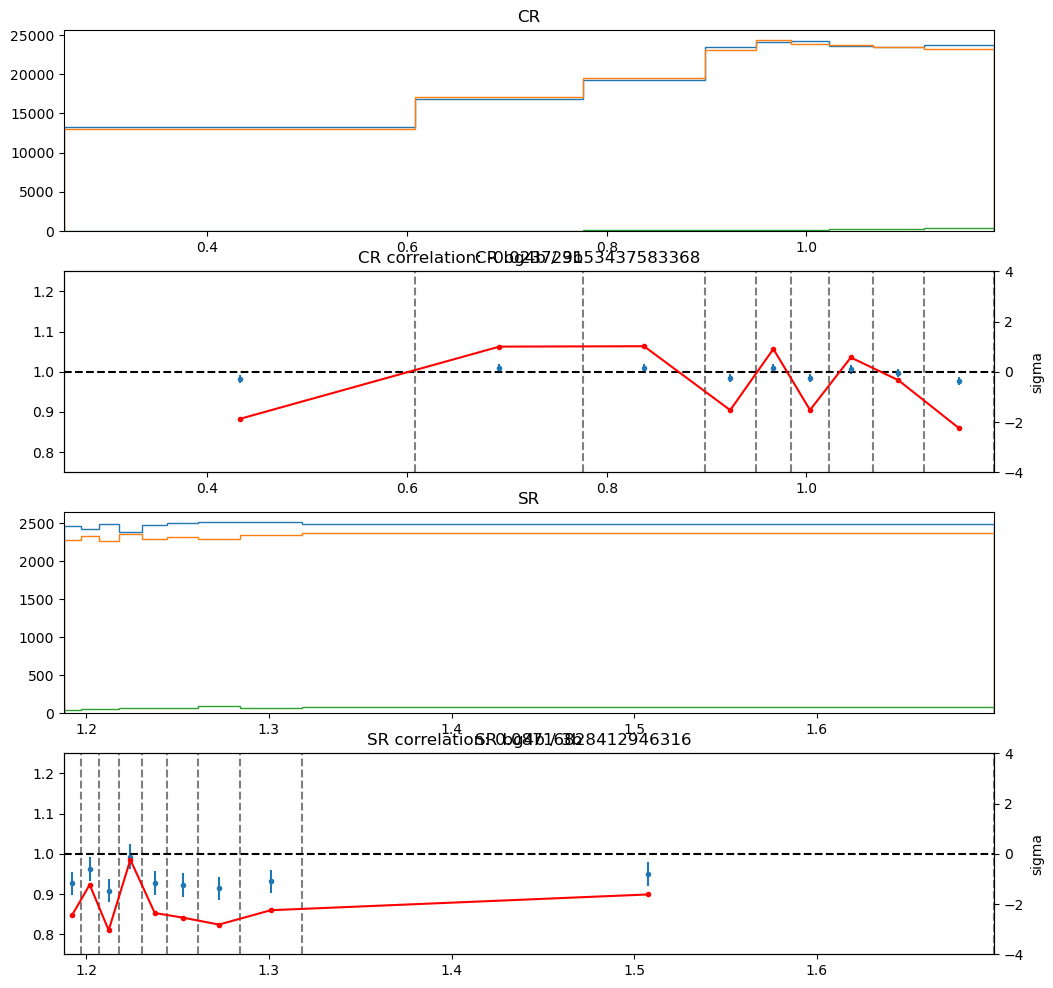

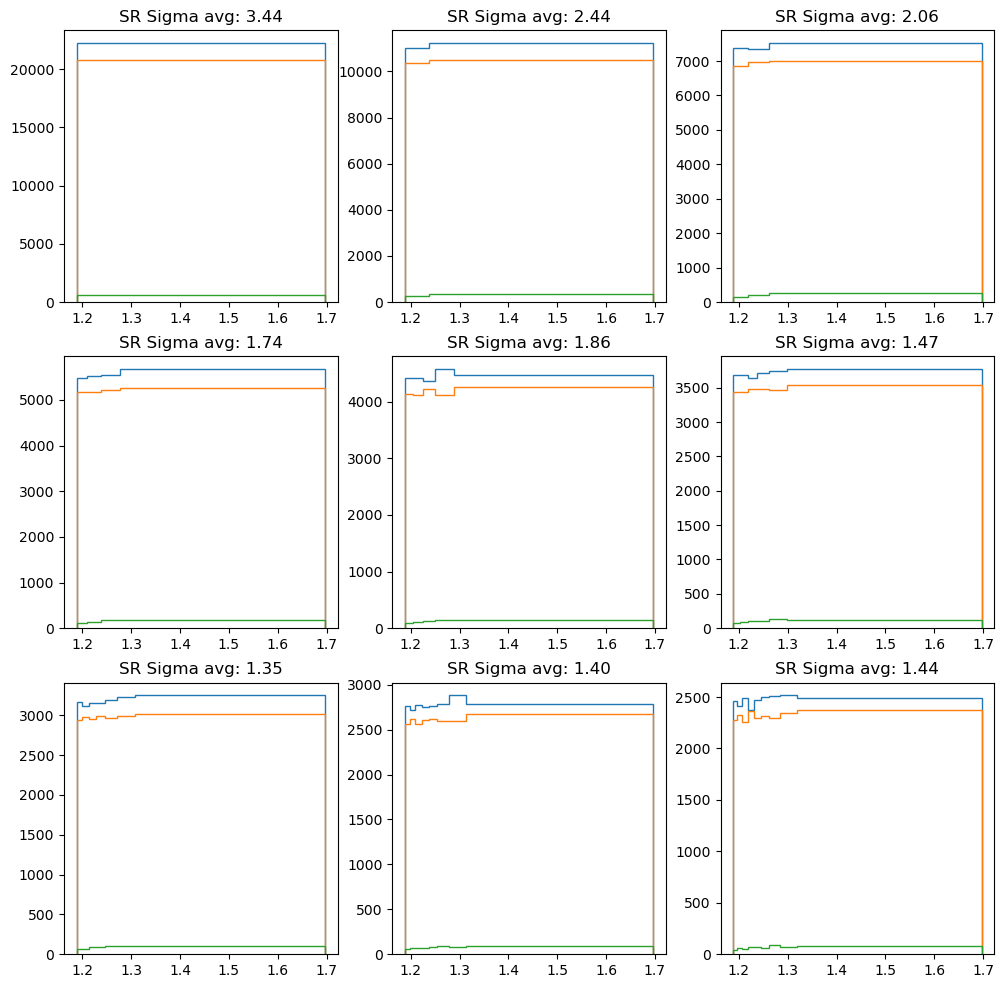

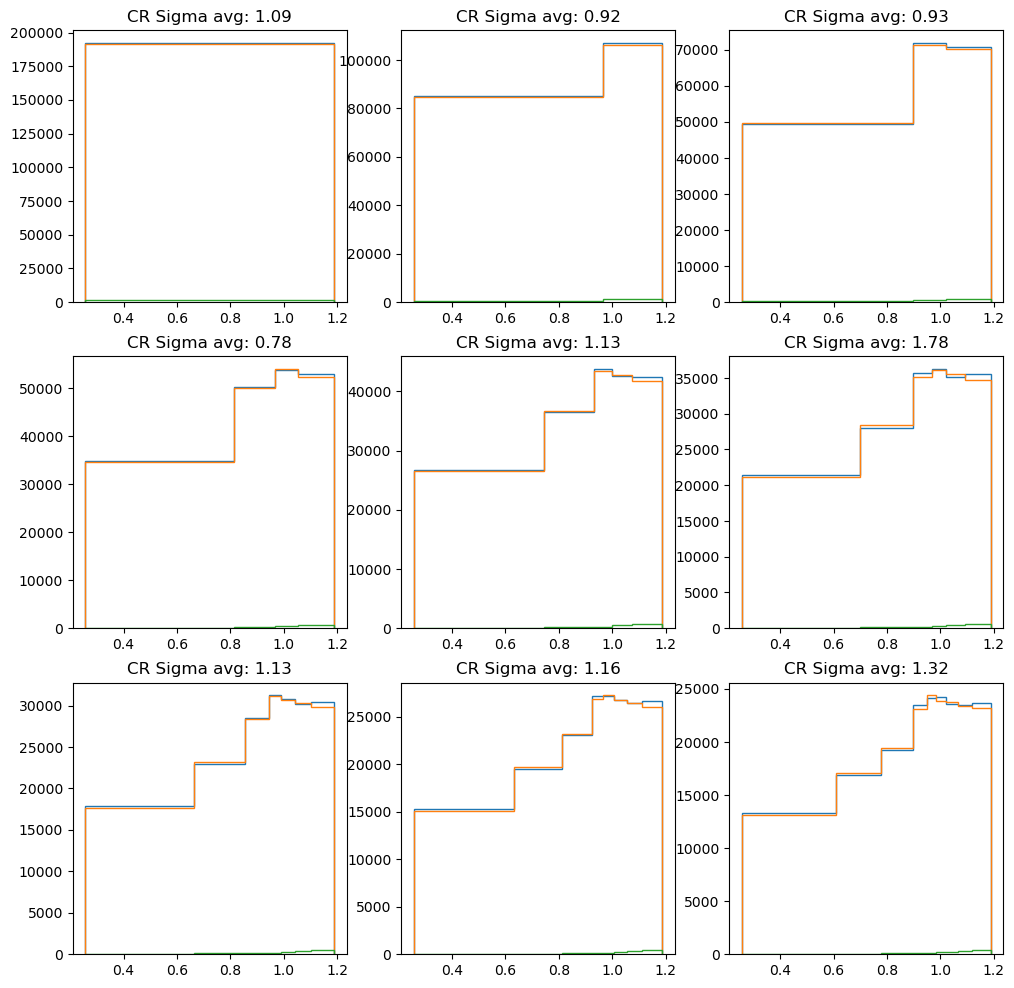

 29%|██▊       | 2/7 [00:49<02:03, 24.78s/it]

************************
seed:  0 signal_ratio:  0.02 rw_method:  CR


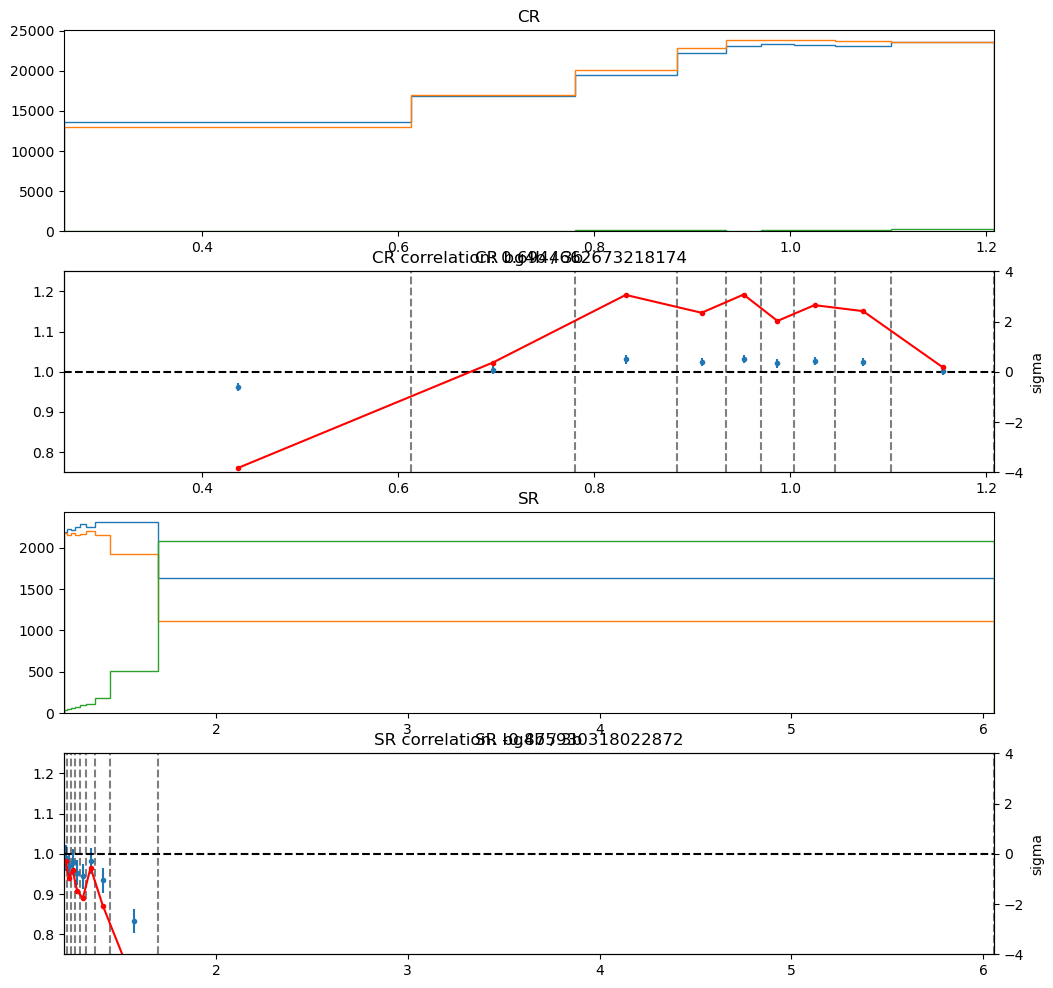

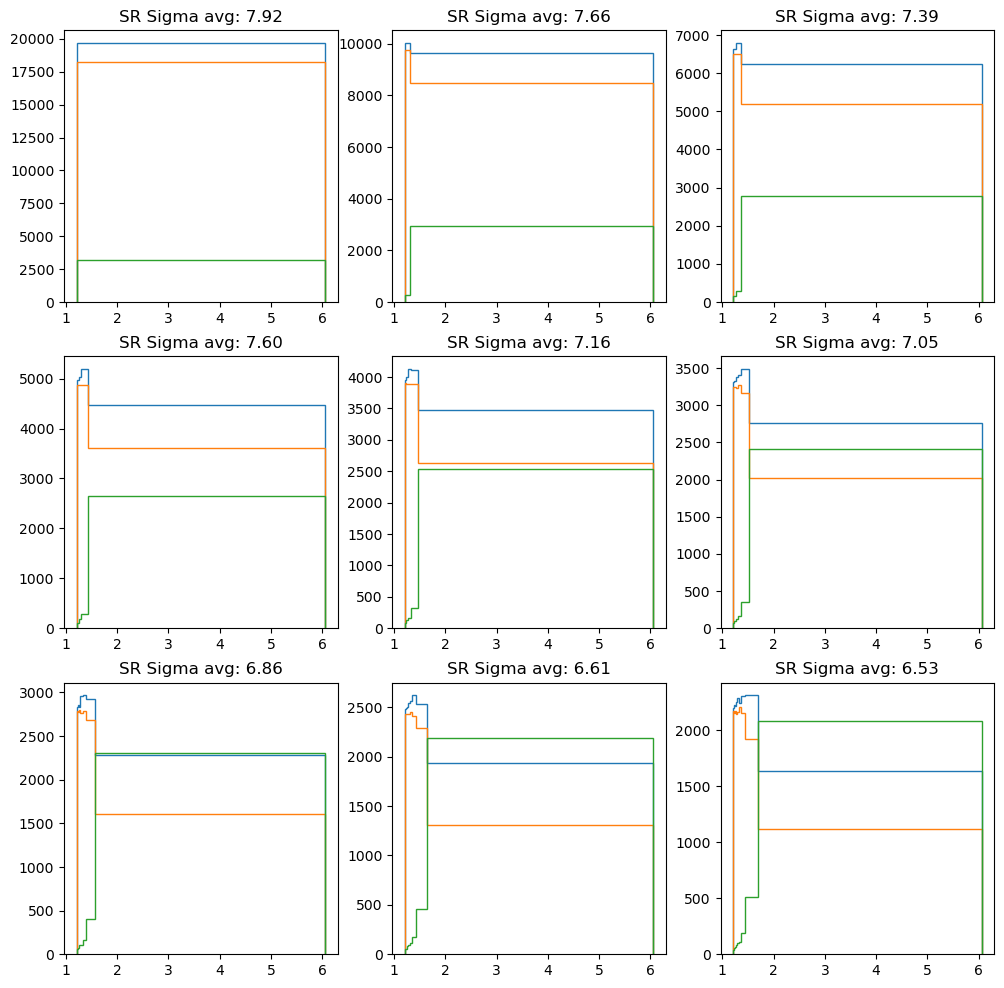

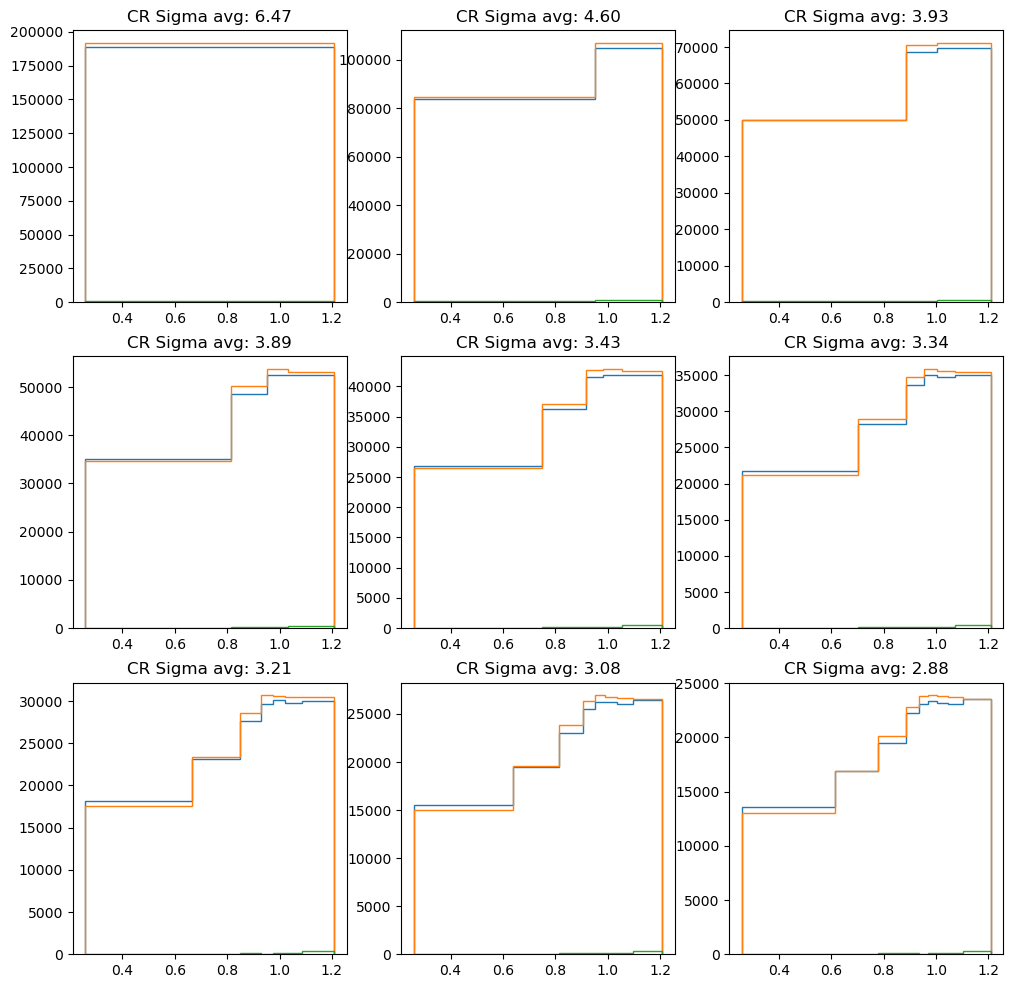

************************
seed:  0 signal_ratio:  0.02 rw_method:  base


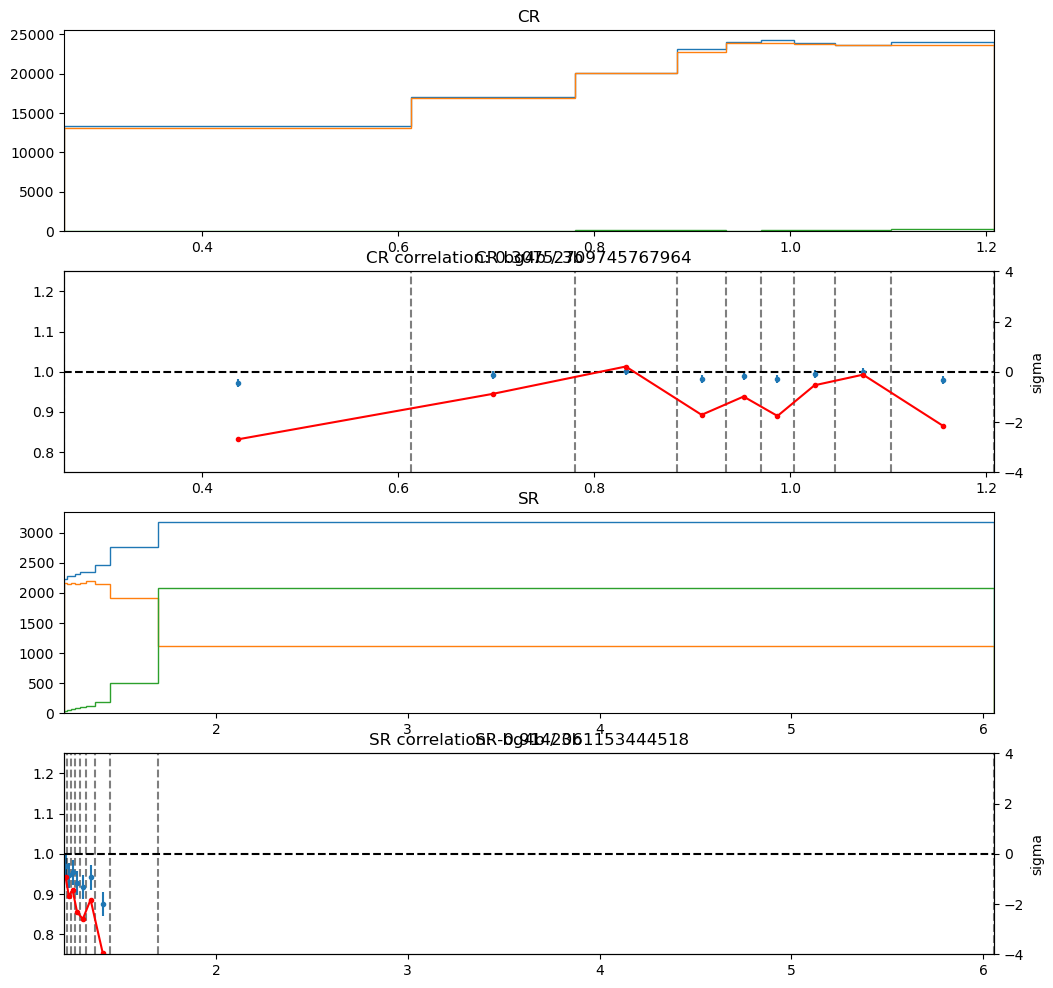

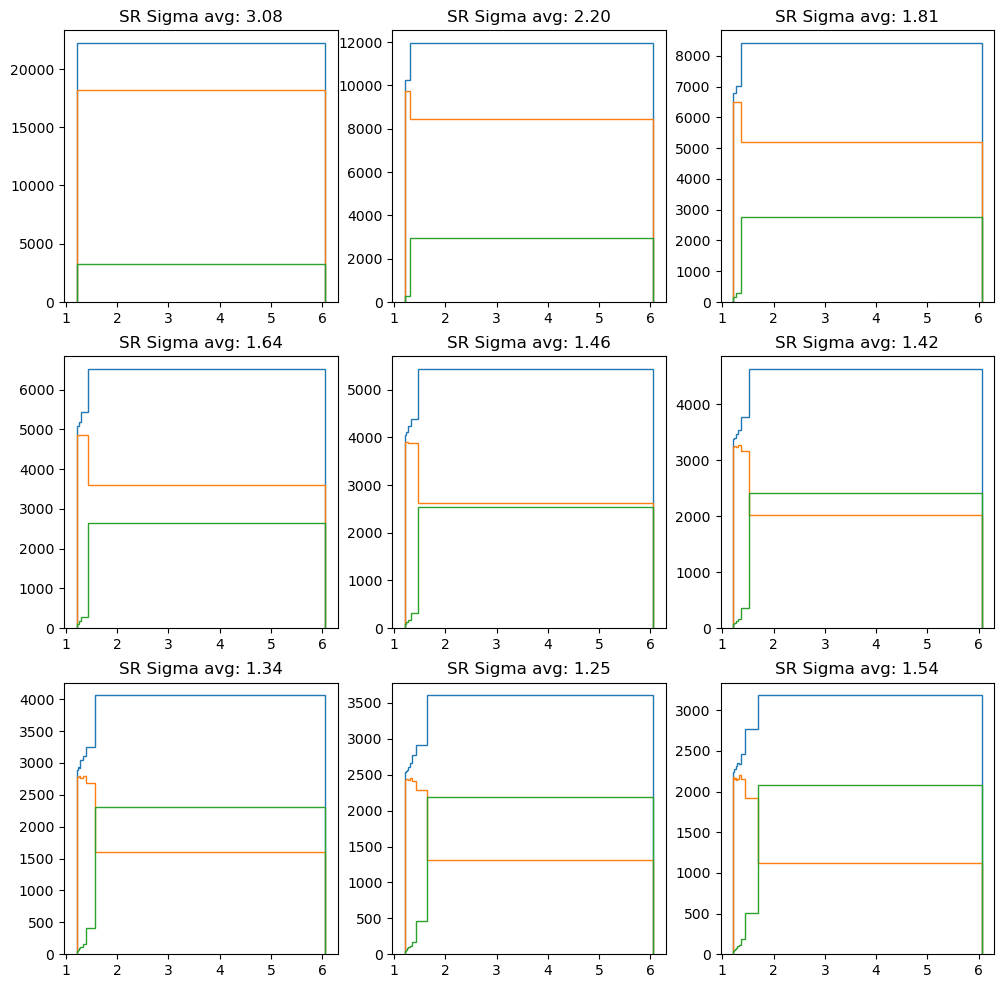

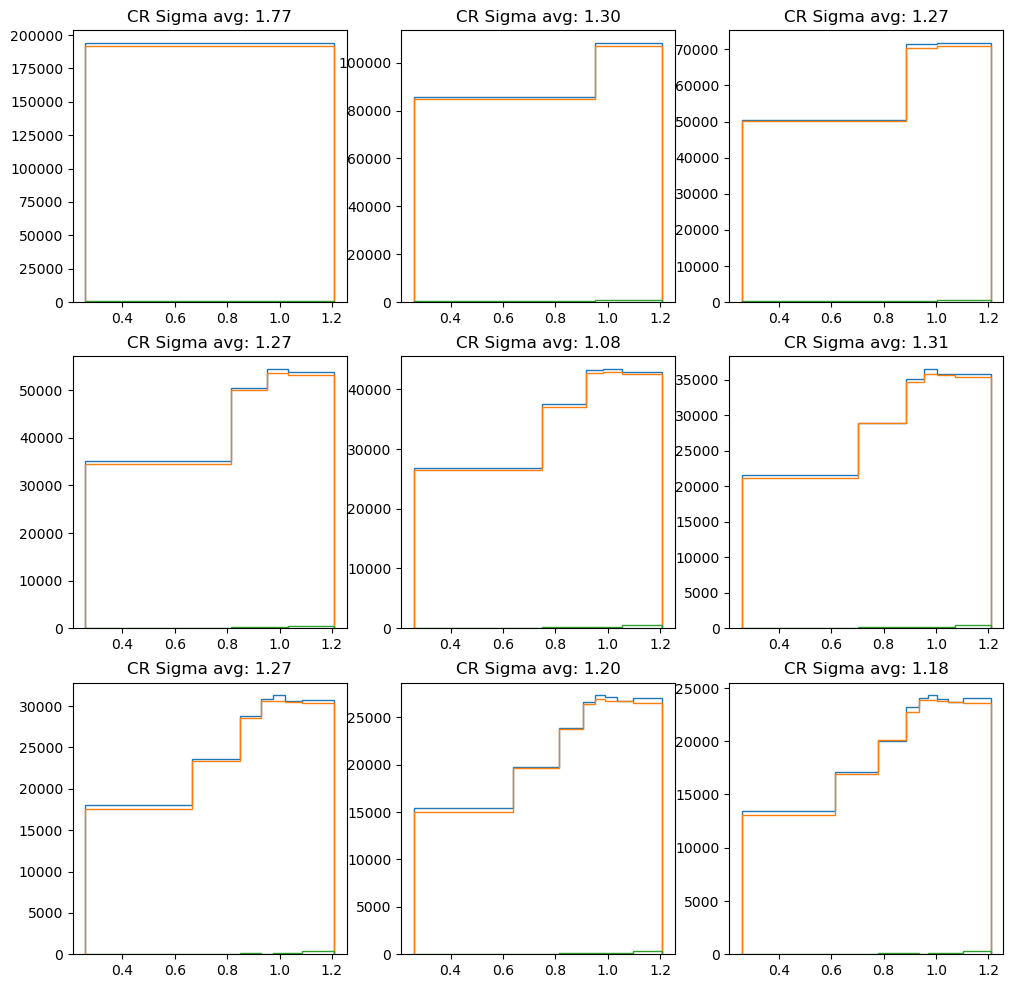

 43%|████▎     | 3/7 [01:14<01:38, 24.54s/it]

************************
seed:  1 signal_ratio:  0.0 rw_method:  CR


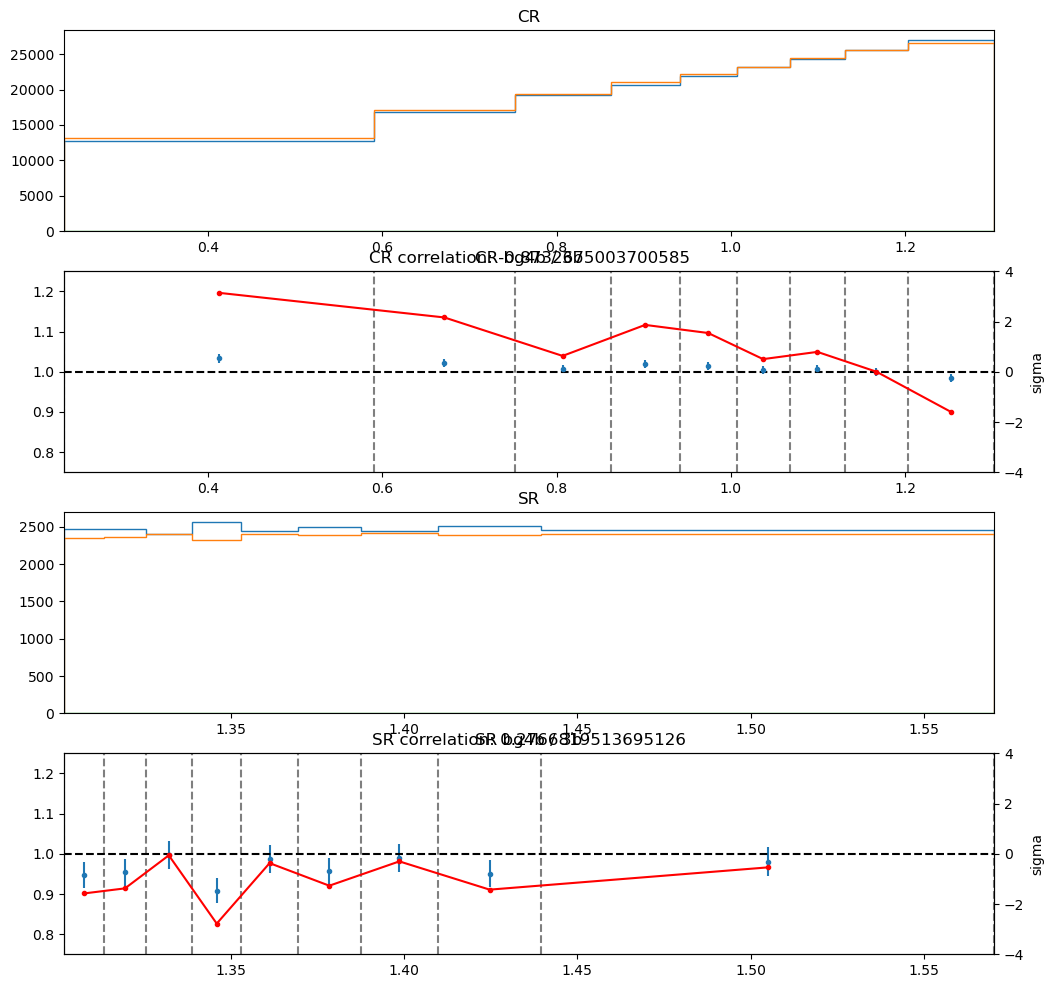

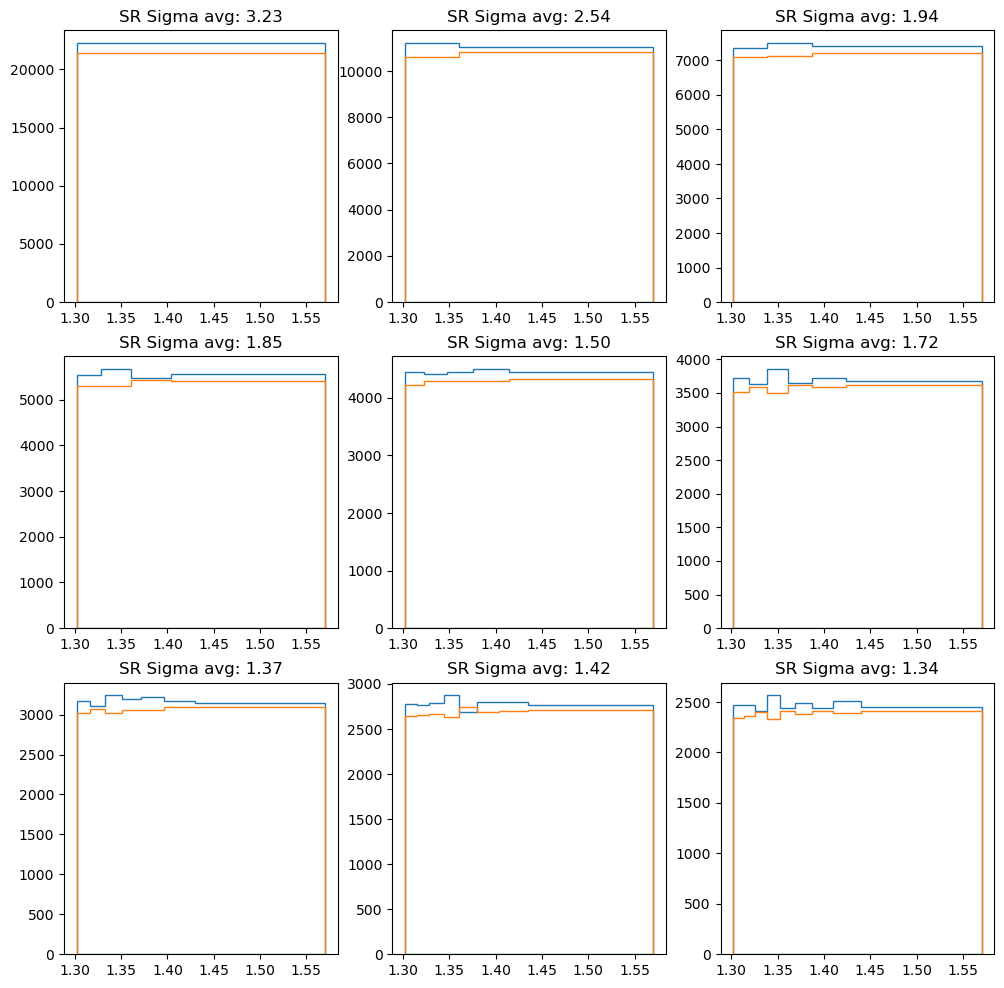

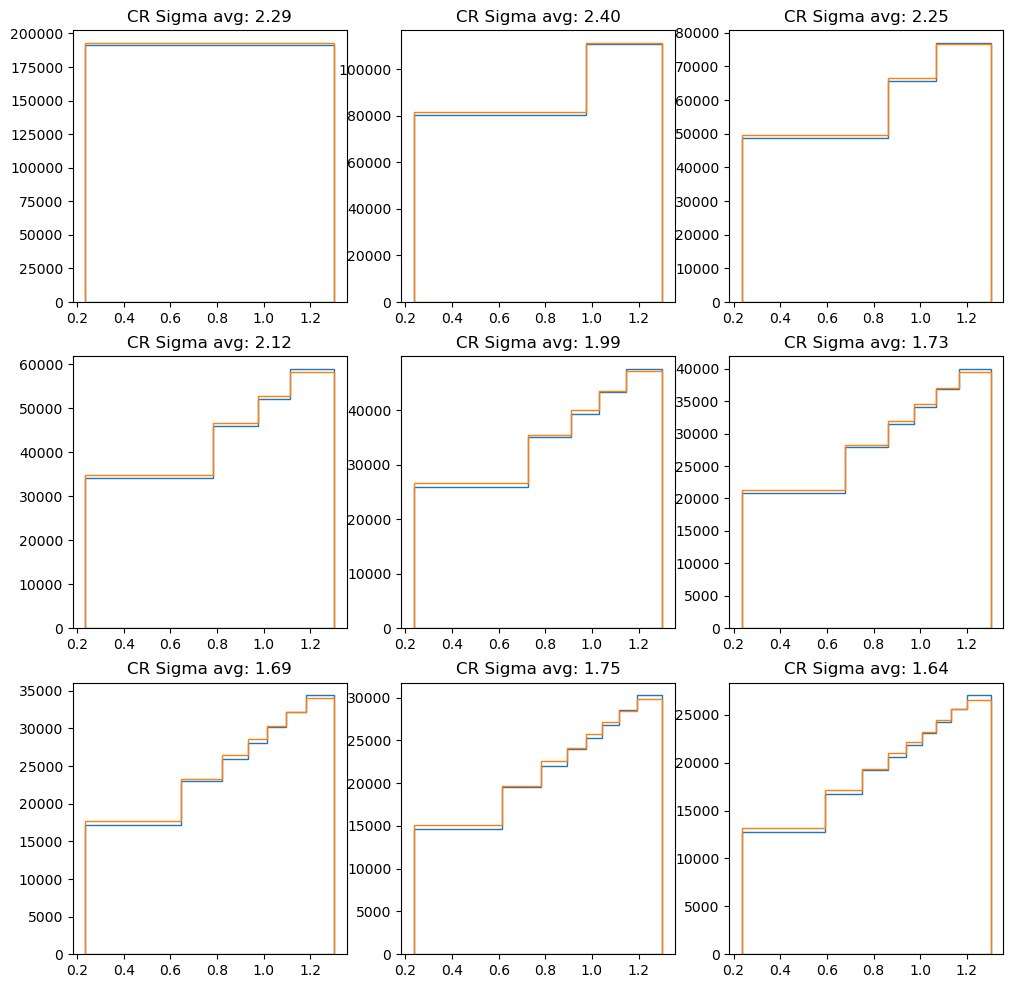

************************
seed:  1 signal_ratio:  0.0 rw_method:  base


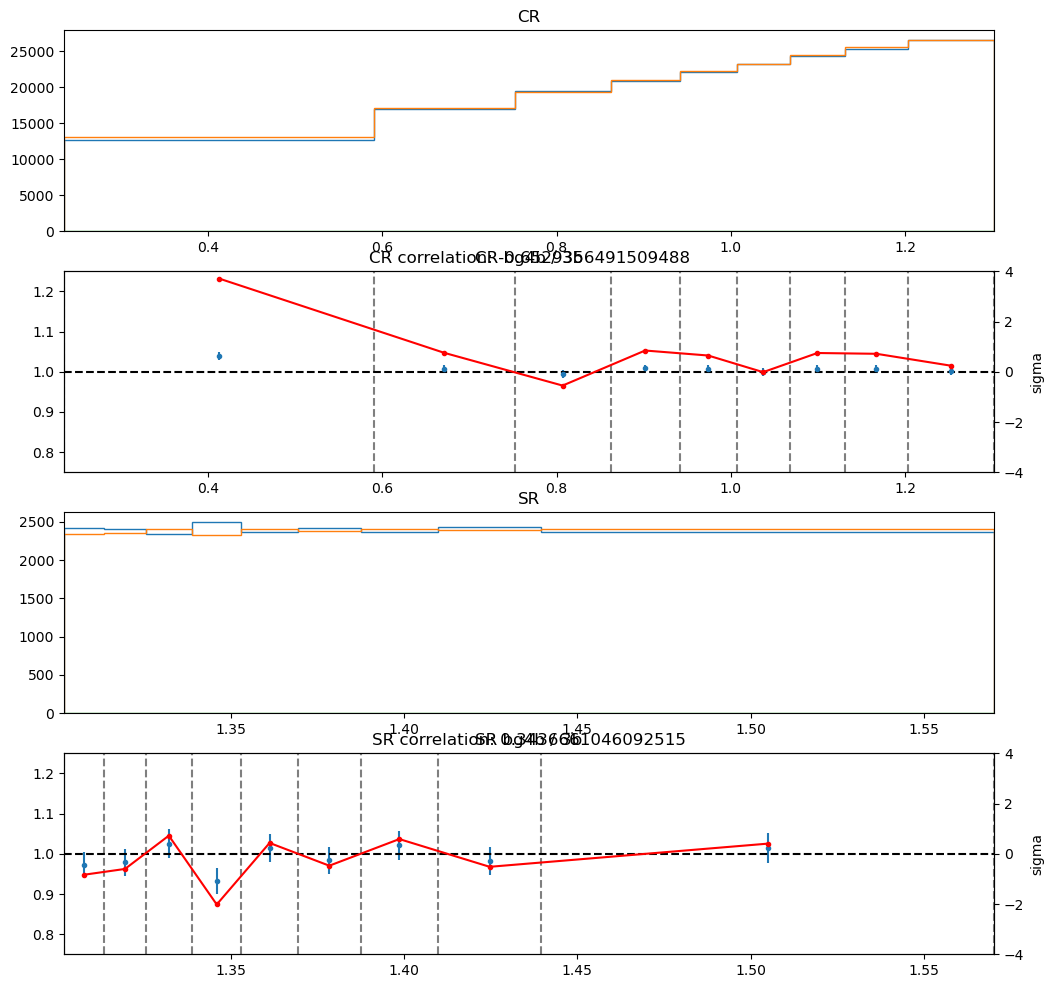

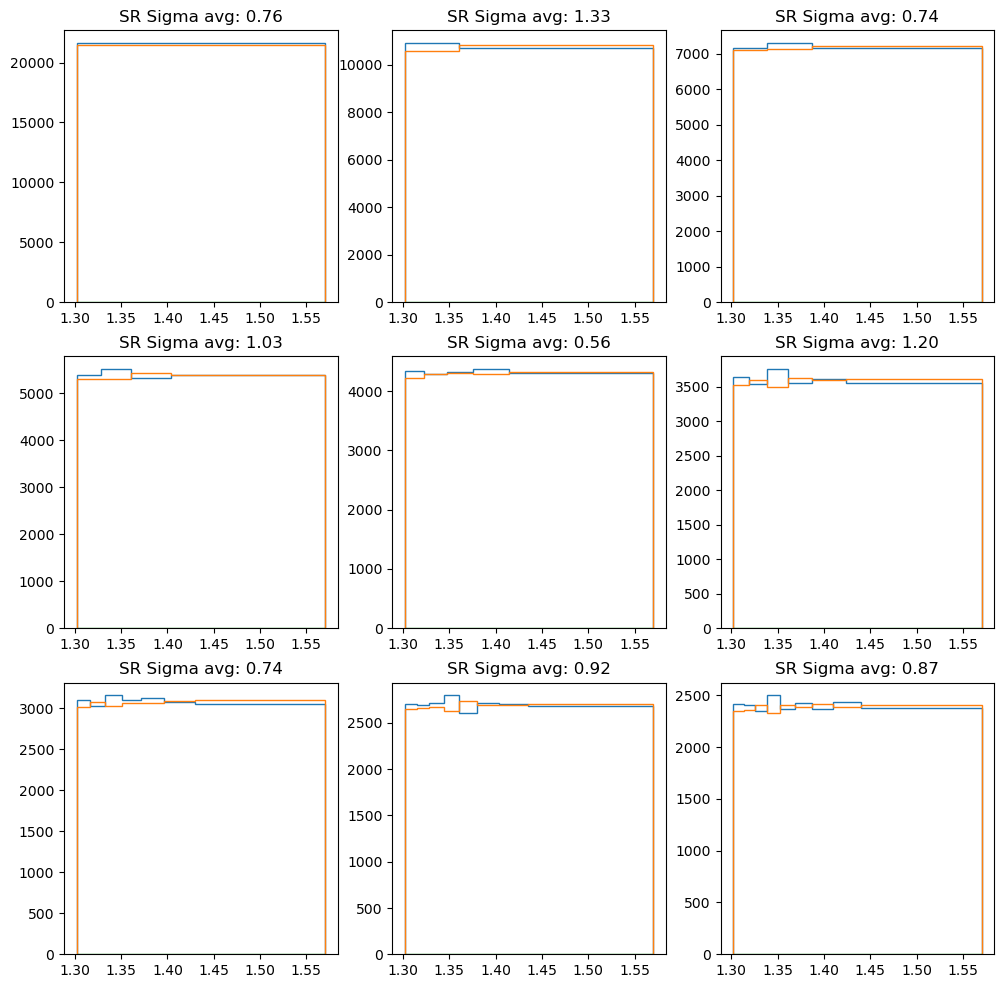

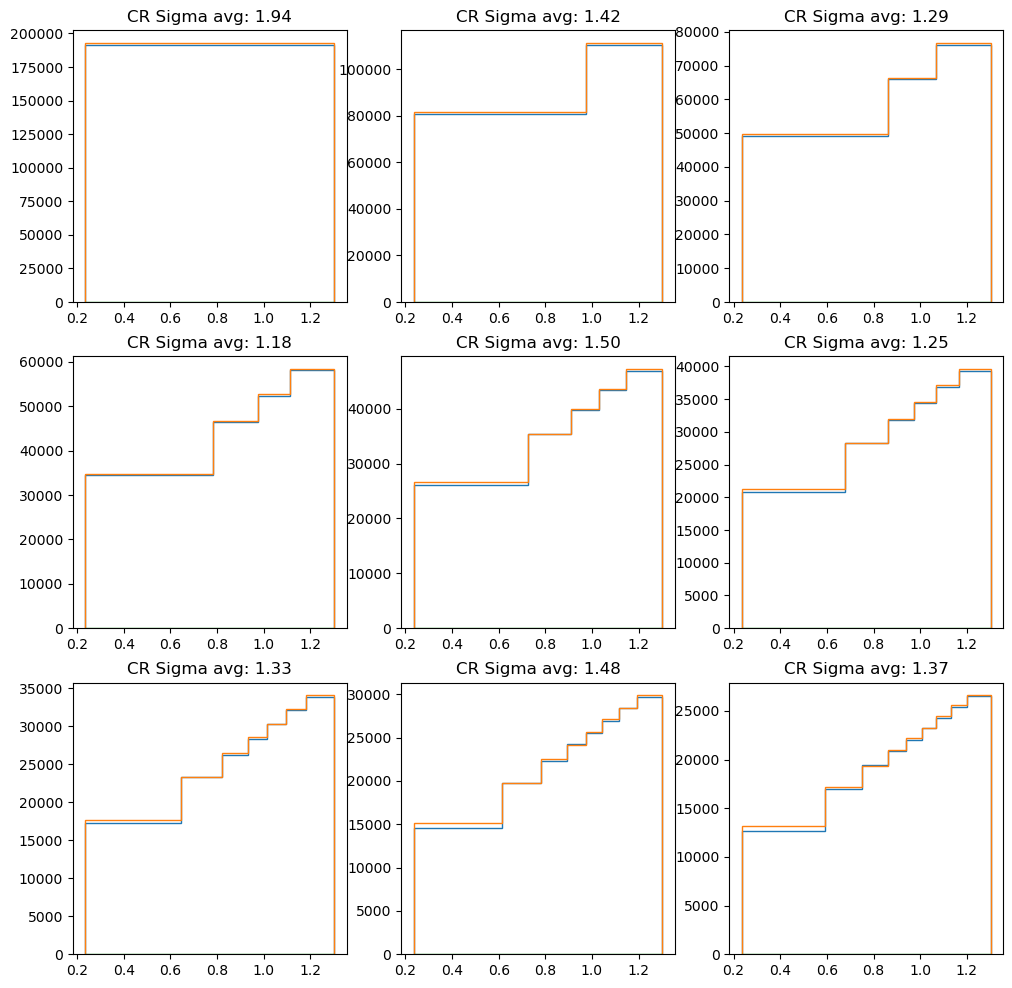

 57%|█████▋    | 4/7 [01:37<01:12, 24.25s/it]

************************
seed:  1 signal_ratio:  0.01 rw_method:  CR


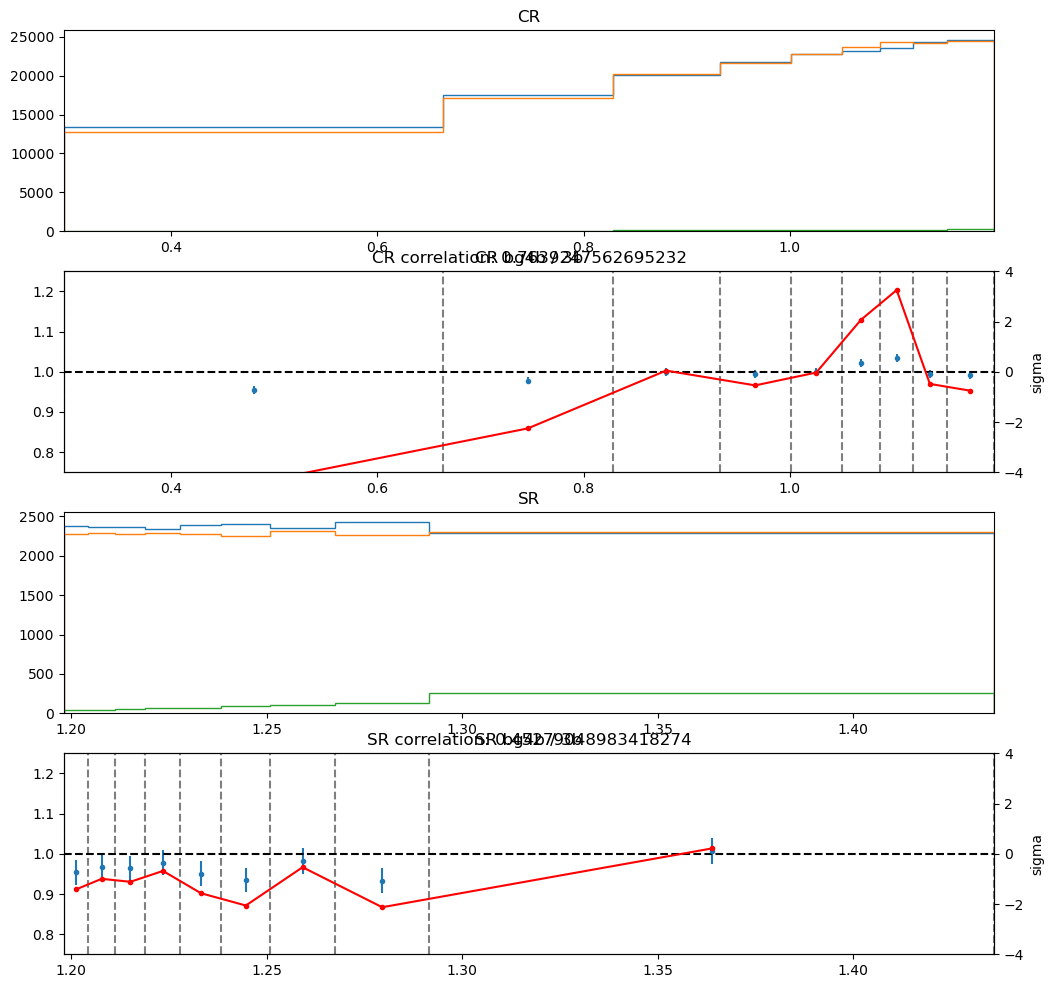

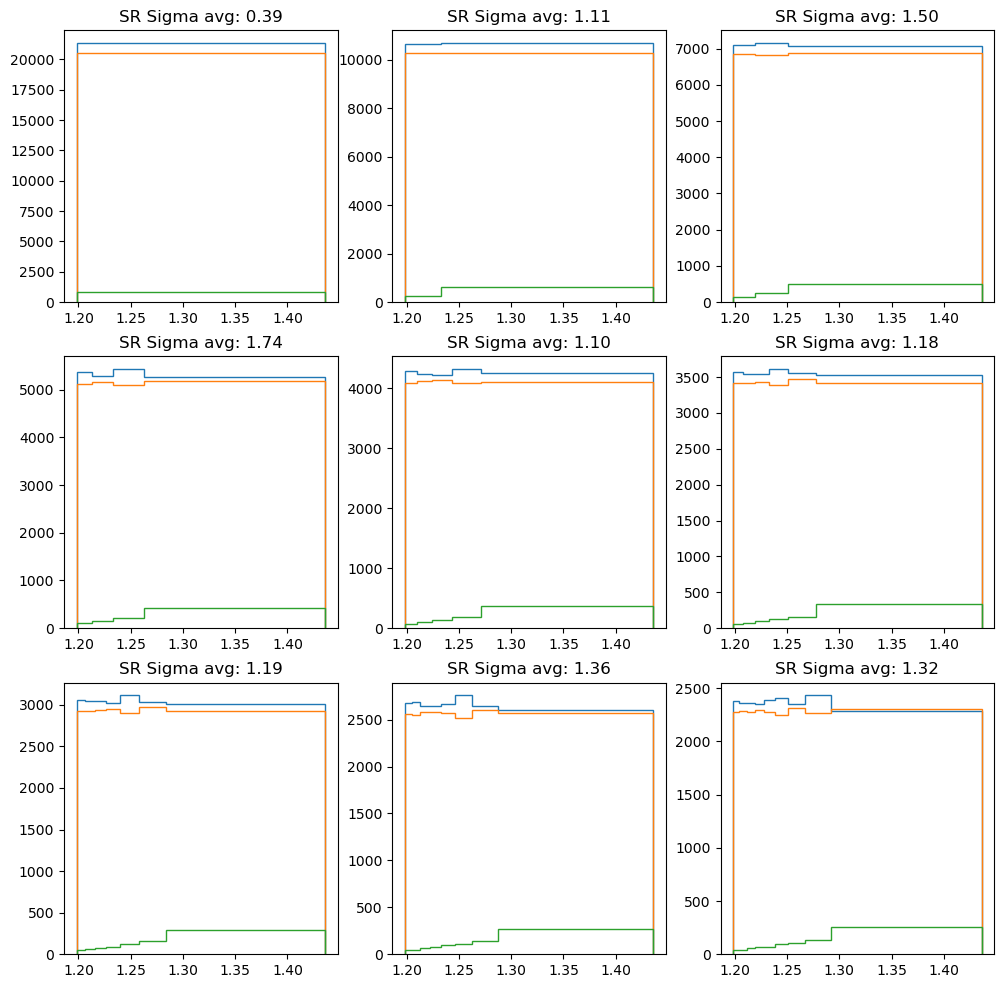

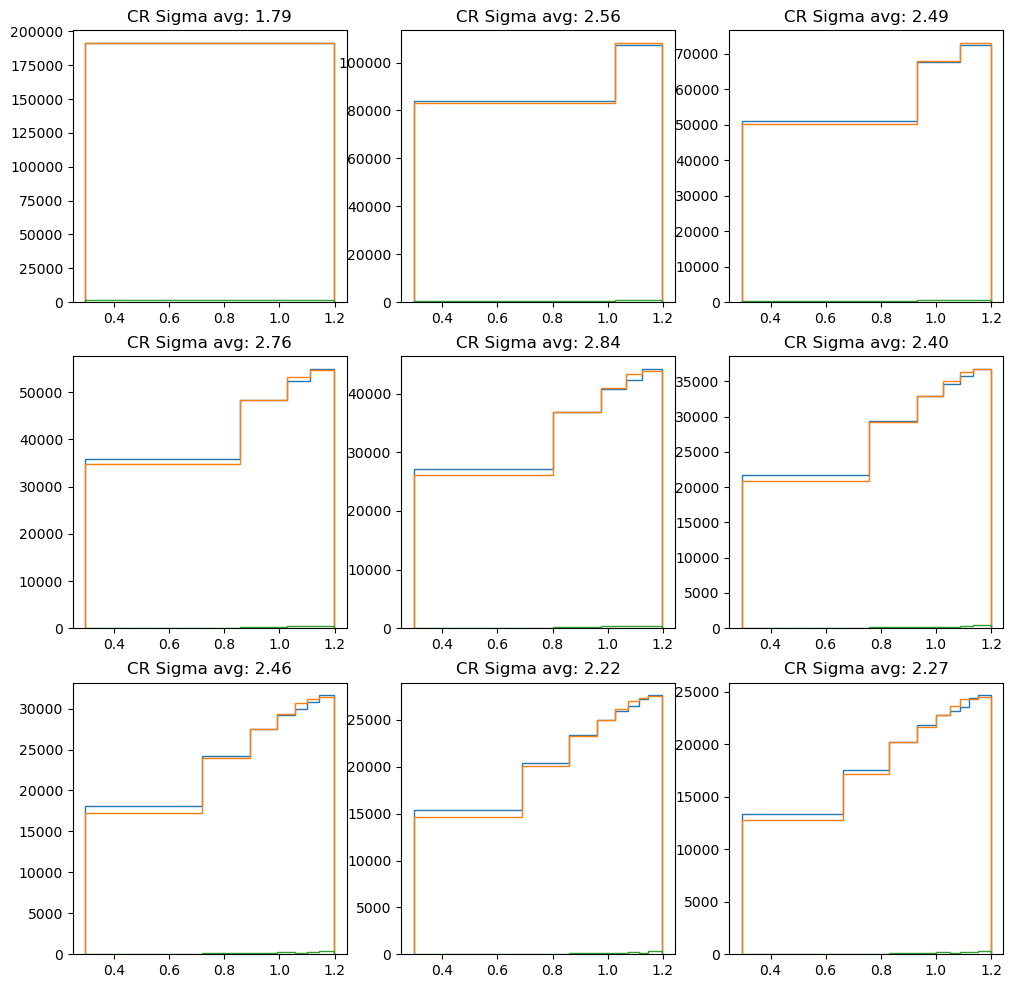

************************
seed:  1 signal_ratio:  0.01 rw_method:  base


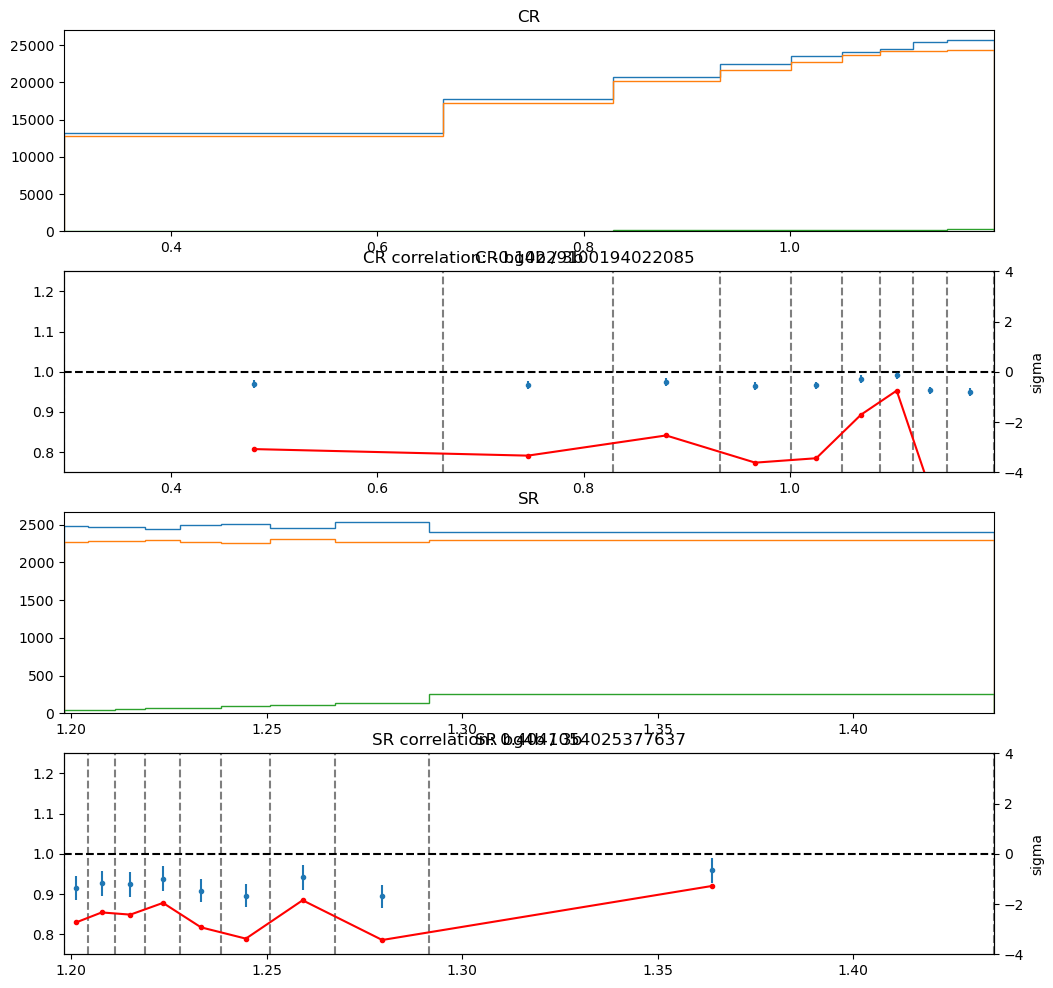

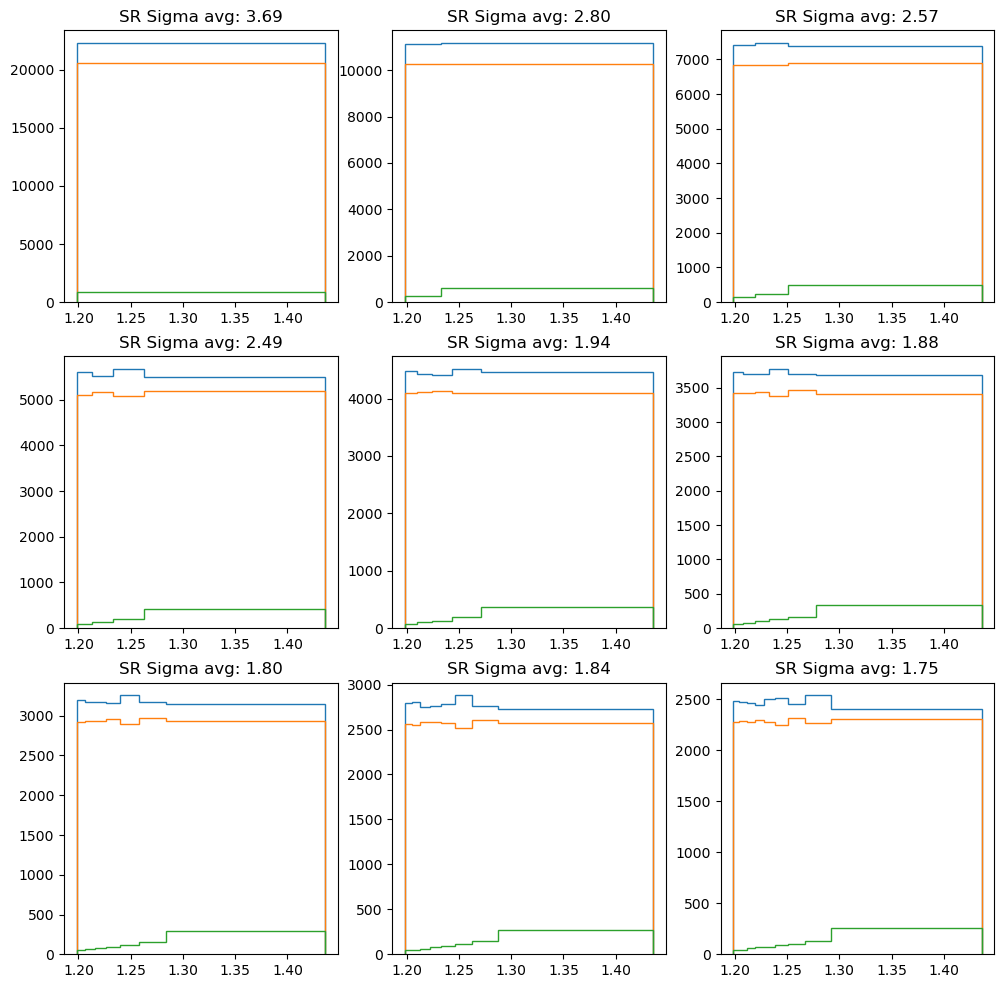

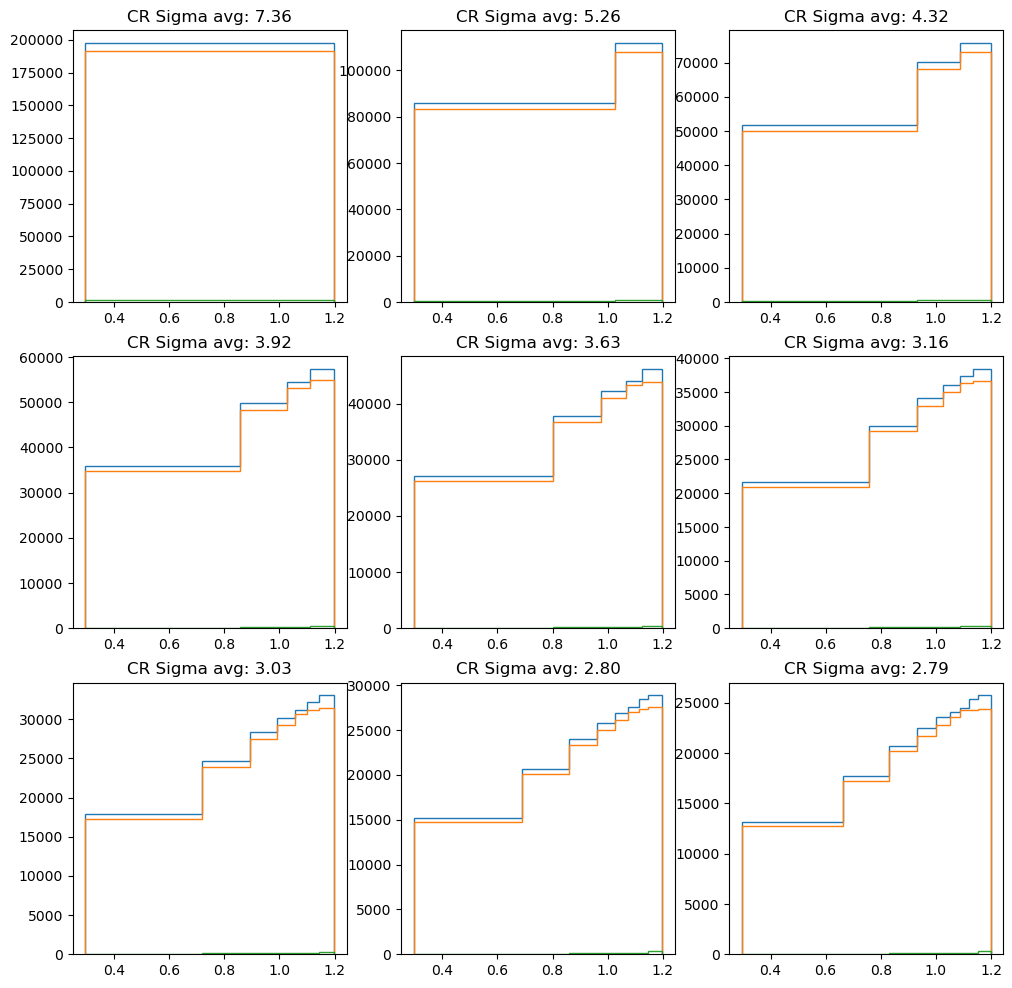

 71%|███████▏  | 5/7 [02:02<00:48, 24.46s/it]

************************
seed:  1 signal_ratio:  0.02 rw_method:  CR


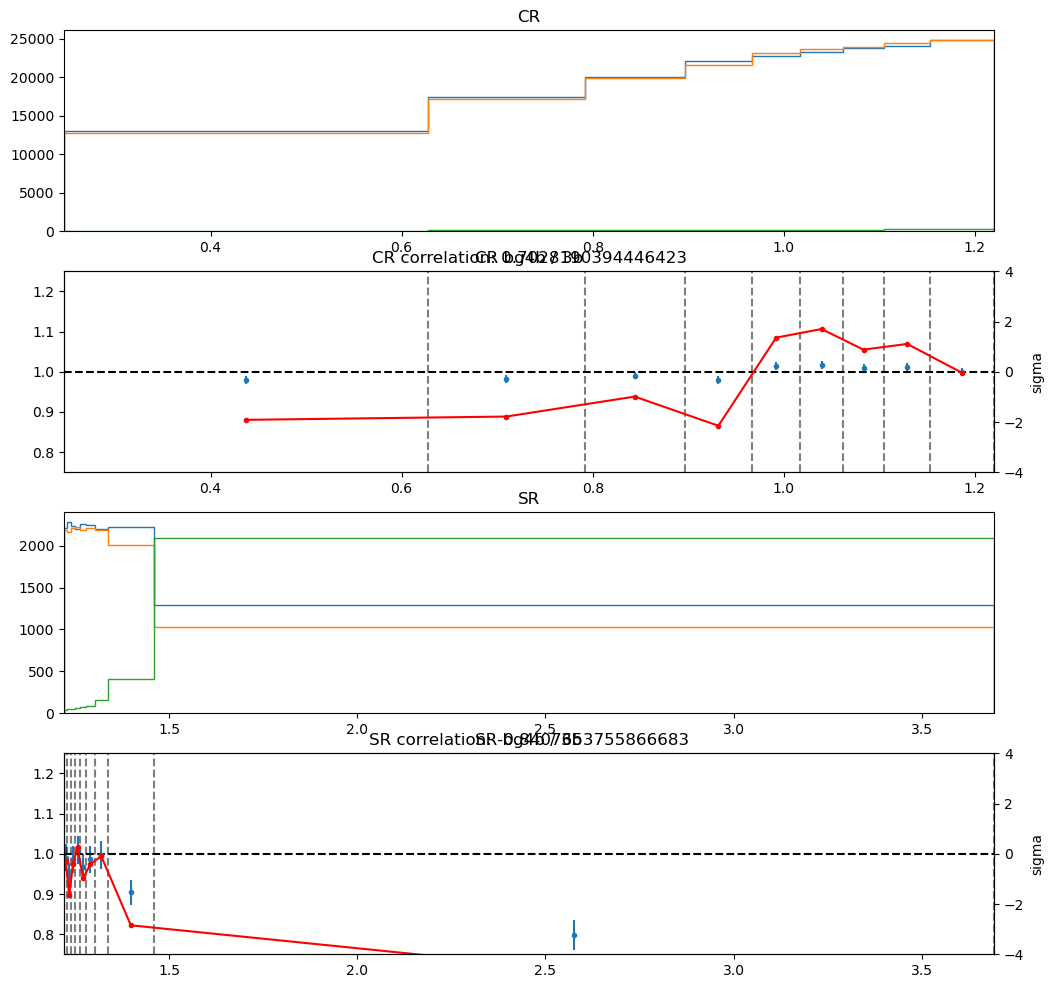

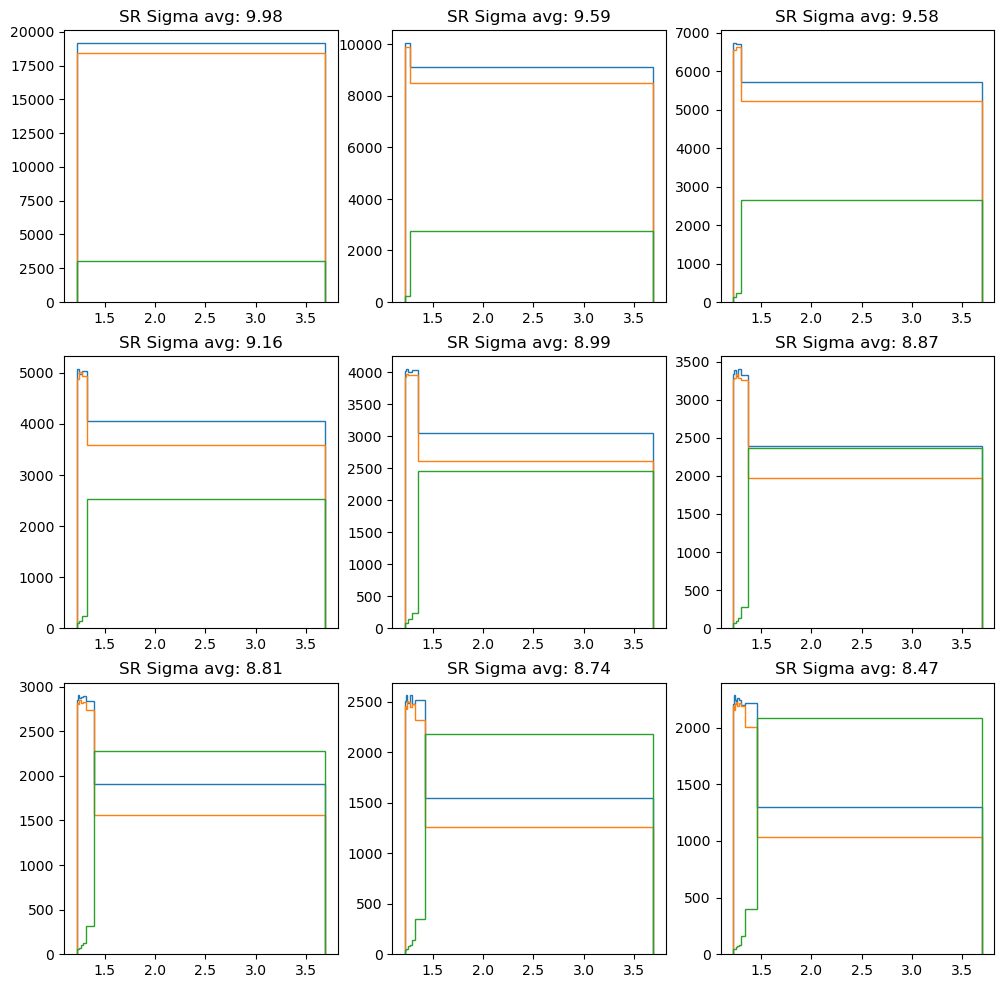

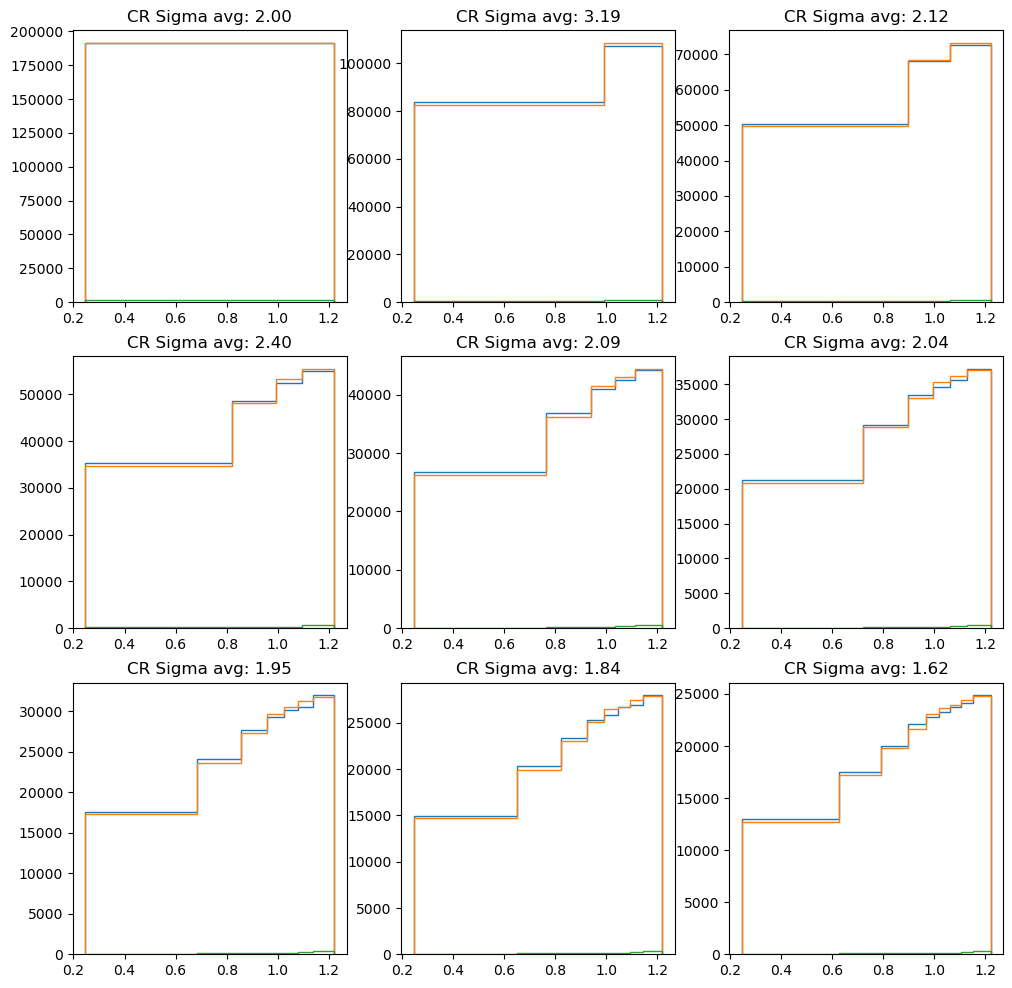

************************
seed:  1 signal_ratio:  0.02 rw_method:  base


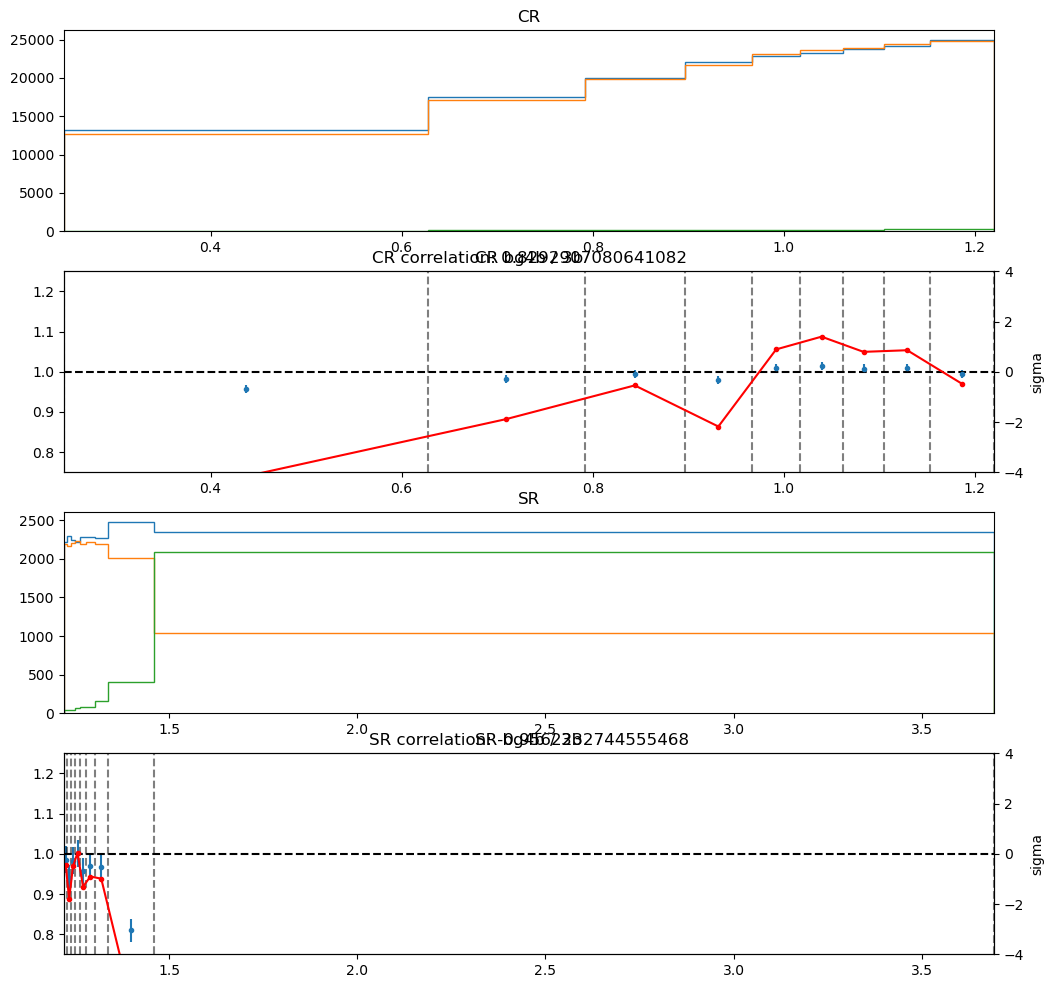

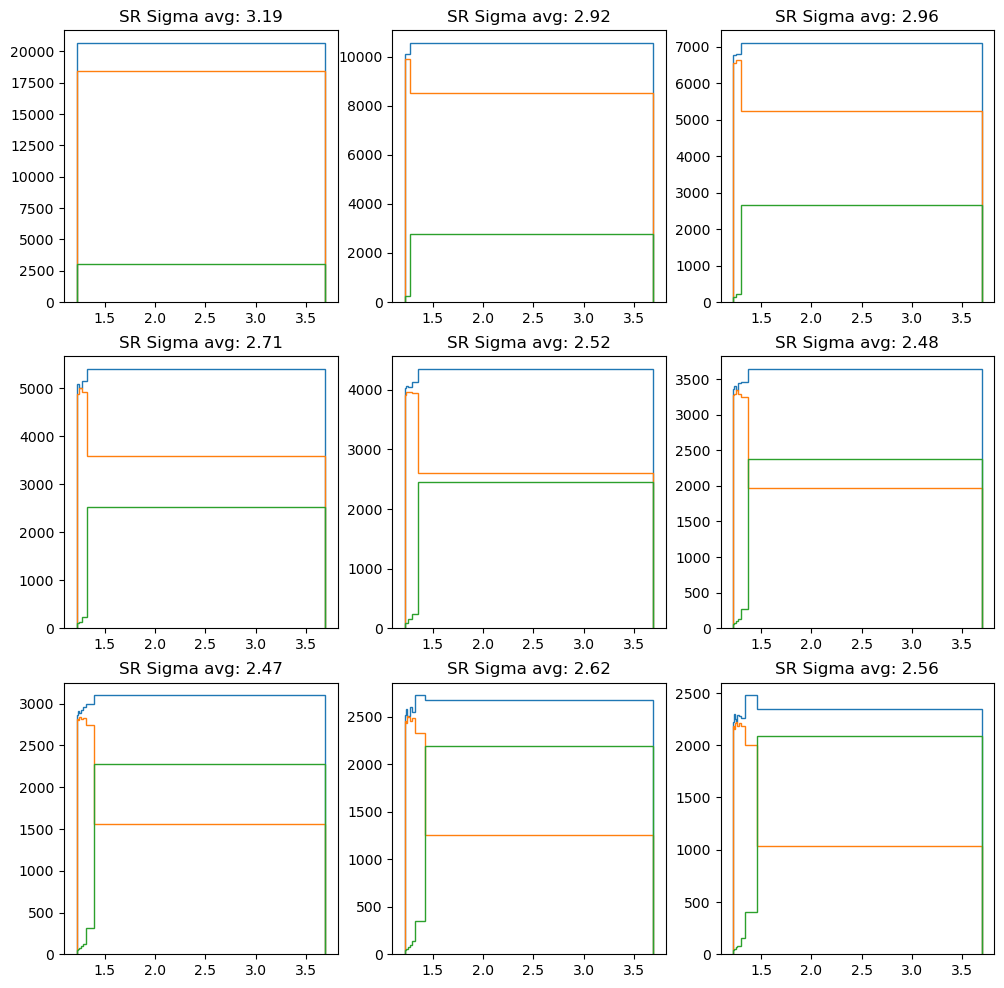

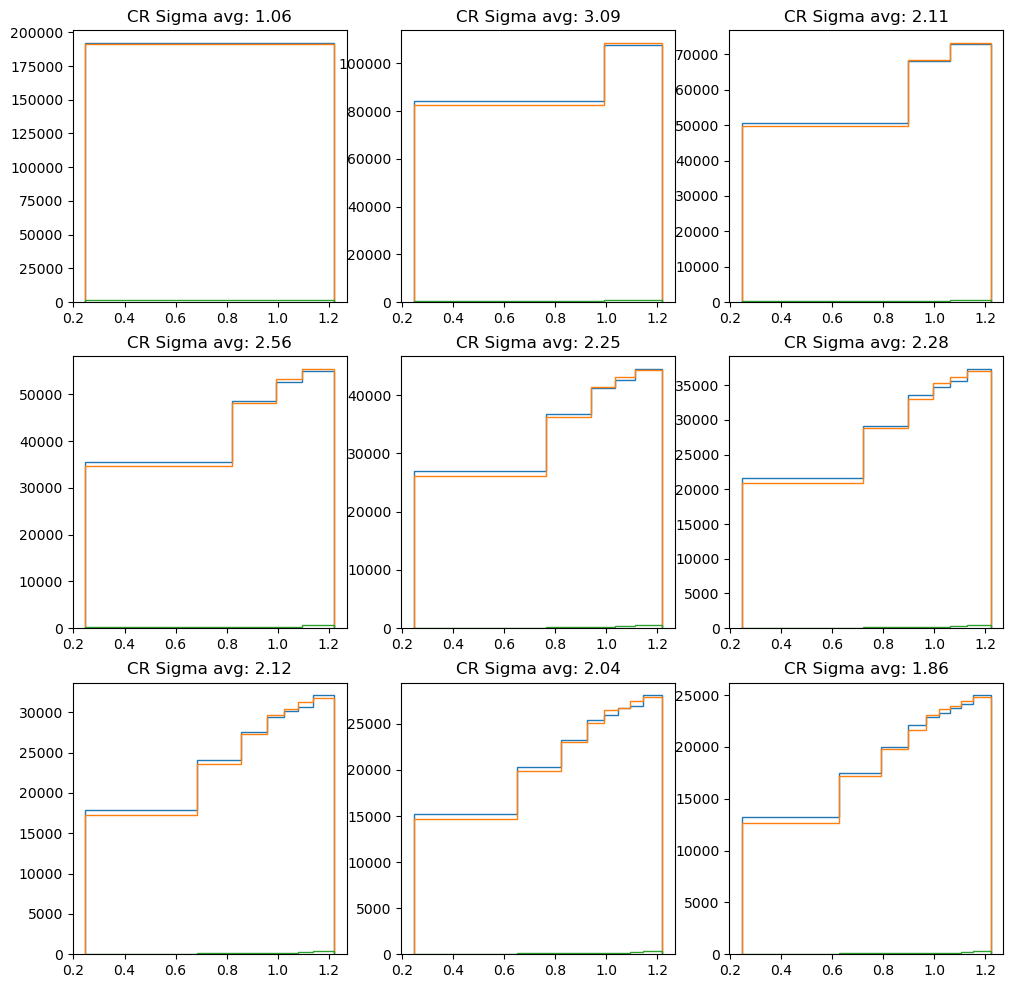

 86%|████████▌ | 6/7 [02:28<00:24, 24.96s/it]

************************
seed:  2 signal_ratio:  0.0 rw_method:  CR


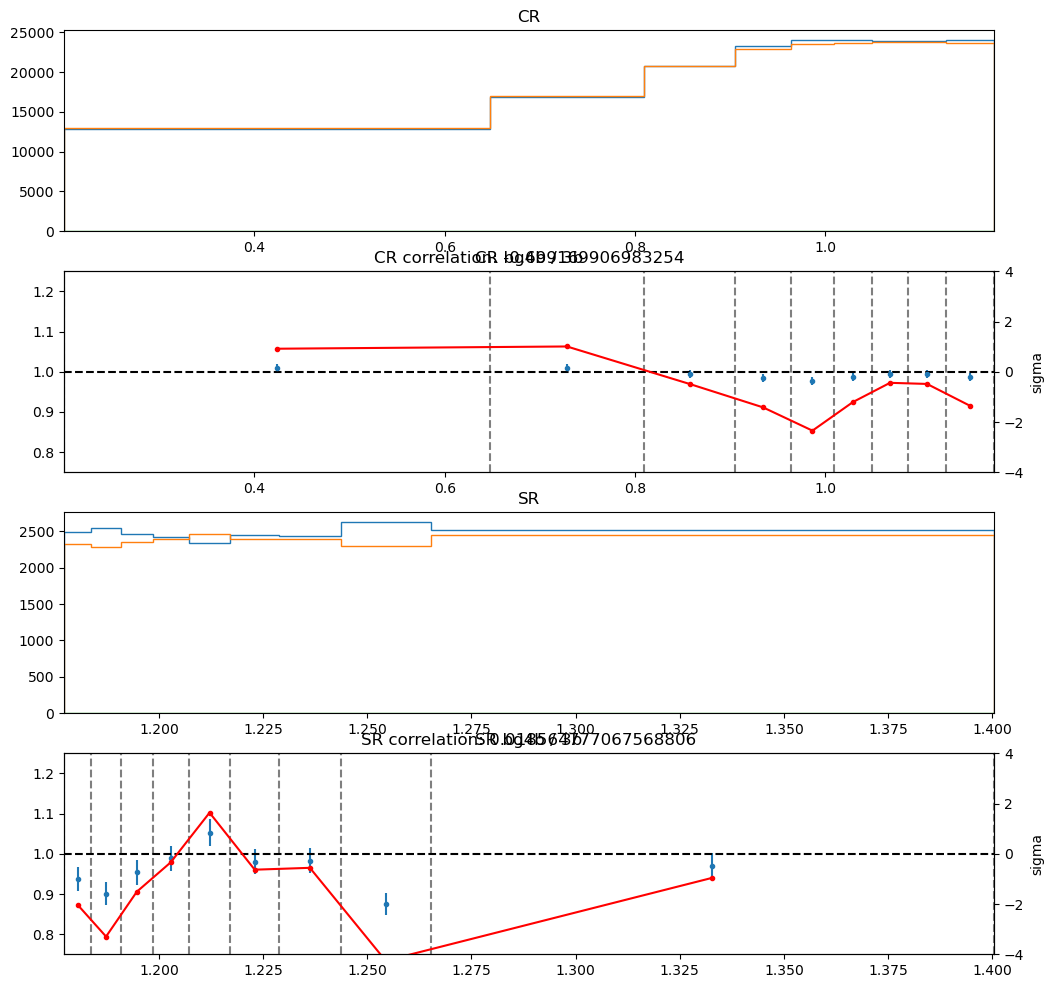

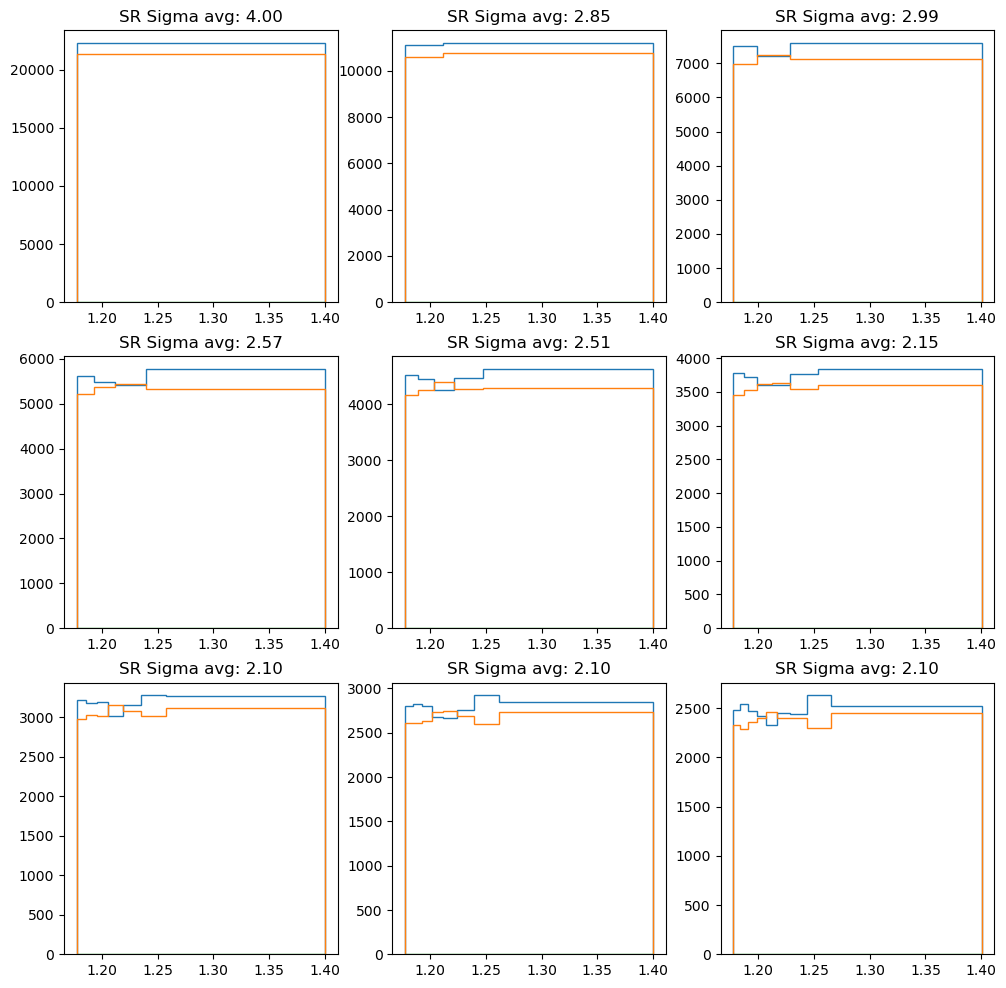

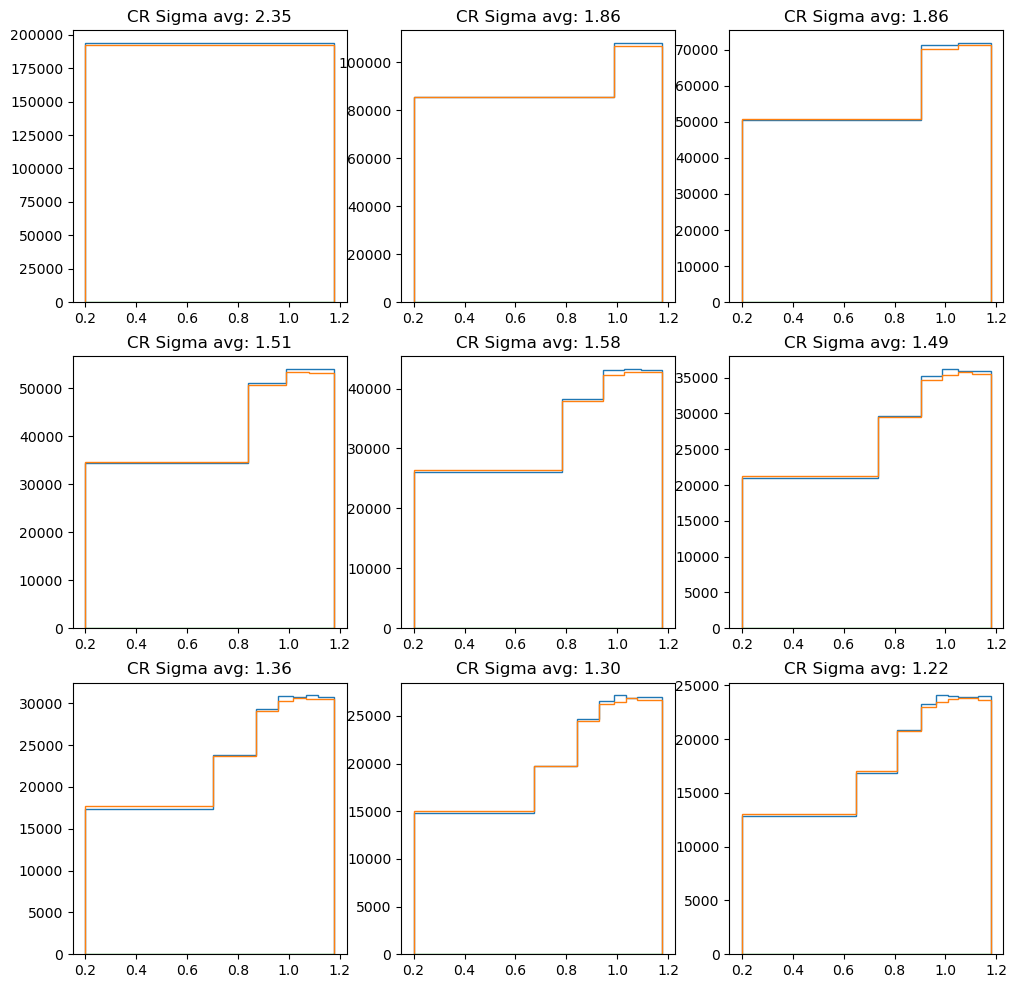

************************
seed:  2 signal_ratio:  0.0 rw_method:  base


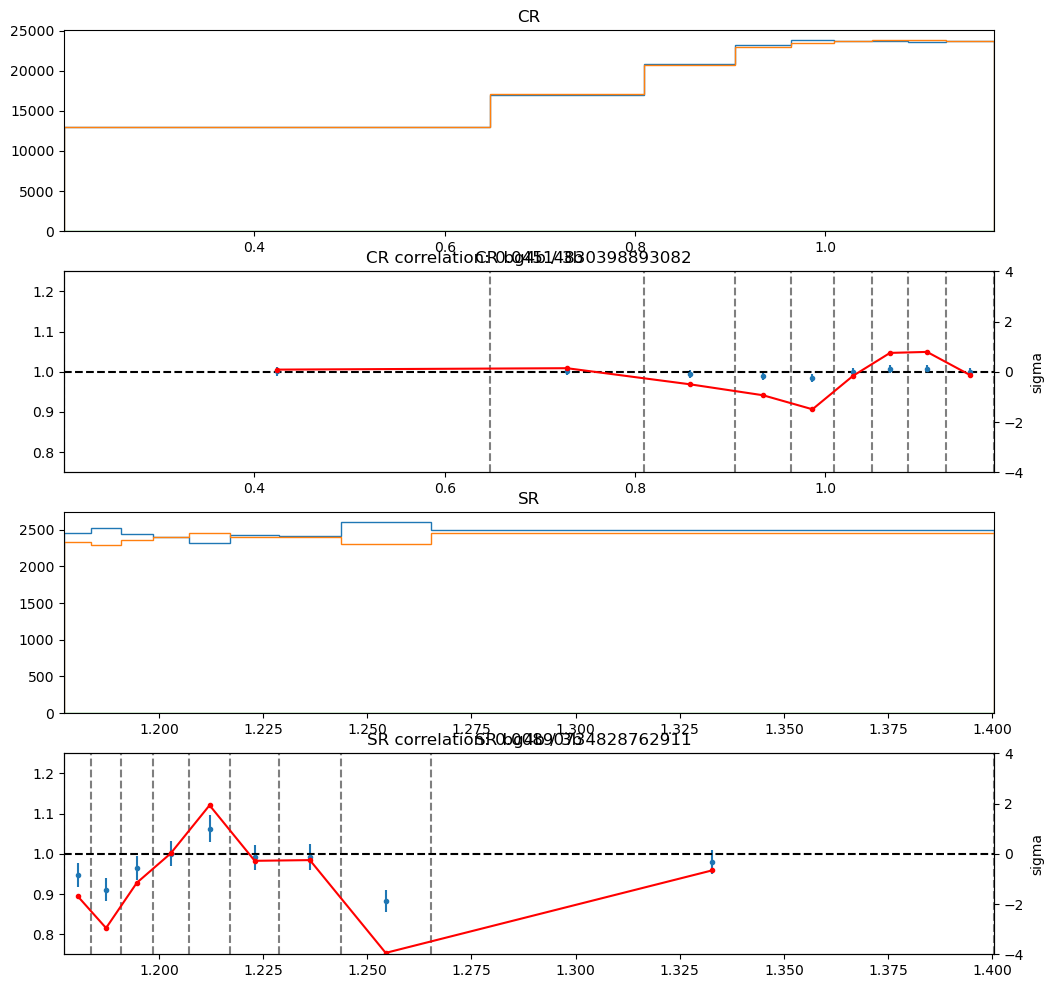

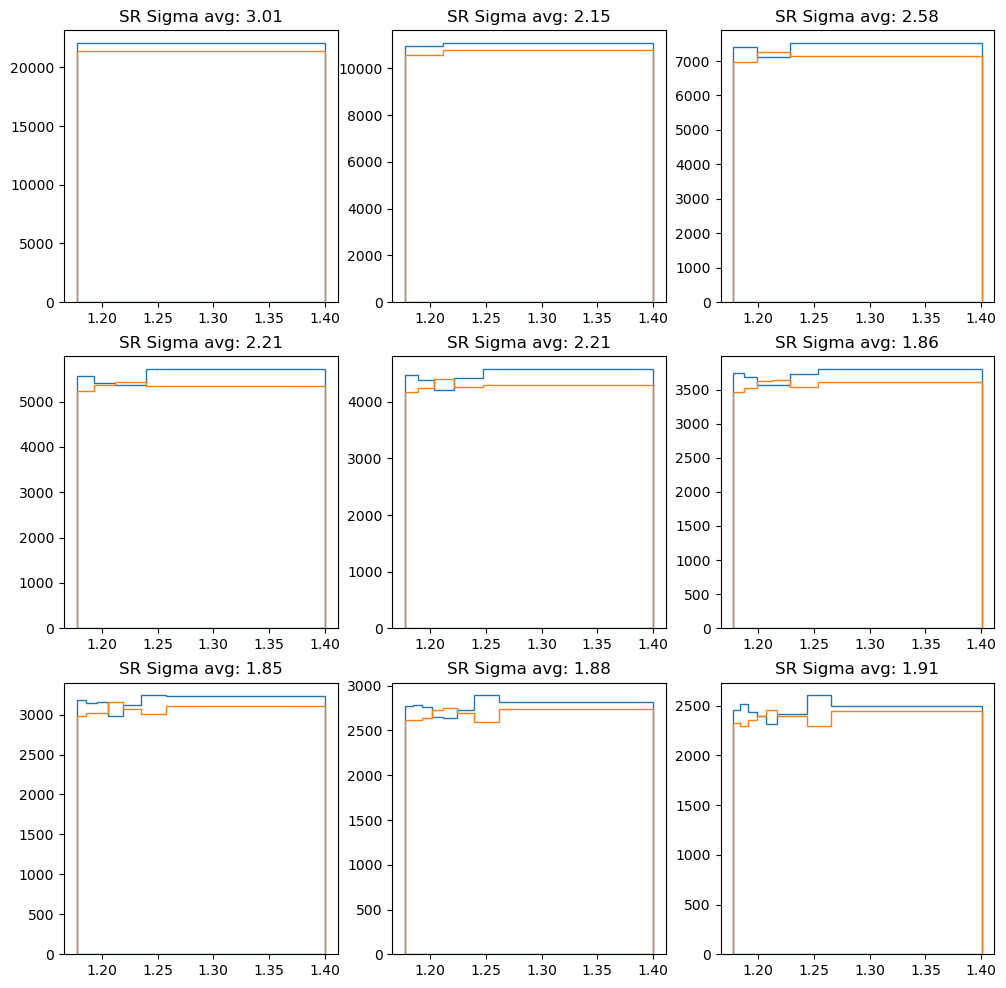

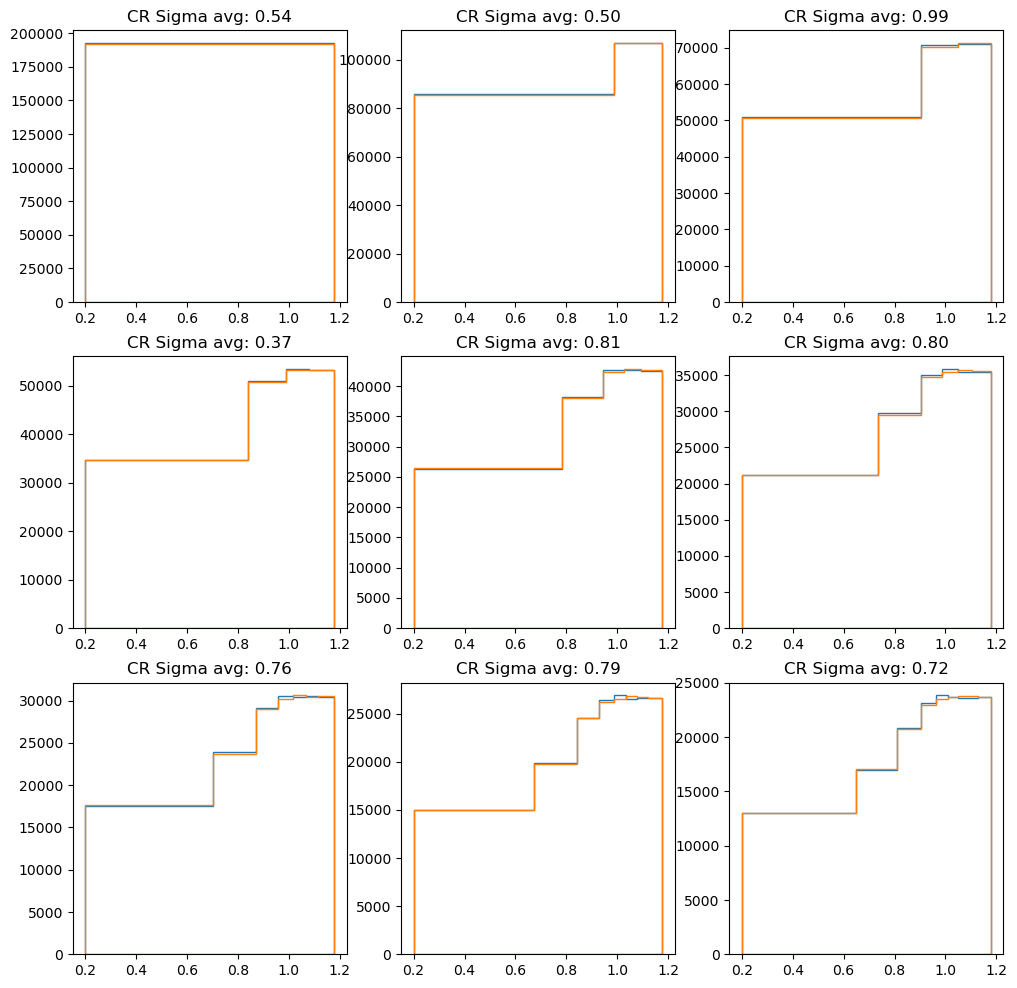

100%|██████████| 7/7 [02:53<00:00, 24.85s/it]


In [11]:
import sys
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.rcParams["lines.markersize"] = 3

verbose = False
show_plots = False
hparam_filter = {
    "experiment_name": lambda x: x in ["counting_test_high_4b_in_CR"]
}

hashes = TSTInfo.find(hparam_filter)
tst_results_summary = []

for tstinfo_hash in (pbar := tqdm.tqdm(hashes)):

    if tstinfo_hash in [r["hash"] for r in tst_results]:
        continue

    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        
    experiment_name = tstinfo.hparams["experiment_name"]
    
    initialize_with_fvt = True if experiment_name == "counting_test_v2" else False

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    
    base_fvt_hash = tstinfo.base_fvt_tinfo_hash
    fvt_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{base_fvt_hash}_best.ckpt")
    fvt_model.eval()
    
    events_tst.set_model_scores(fvt_model)
    CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
    CR_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{CR_fvt_hash}_best.ckpt")
    CR_model.eval()

    SR_stats = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_SR = SR_stats >= SR_cut
    in_CR = (SR_stats < SR_cut) & (SR_stats >= CR_cut)

    weights_4b = events_tst.weights * events_tst.is_4b
    weights_signal = events_tst.weights * events_tst.is_signal
    
    ratio_4b = tstinfo.hparams["ratio_4b"]
    
    for rw_method in ["CR", "base"]:
        print("************************")
        print("seed: ", seed, "signal_ratio: ", signal_ratio, "rw_method: ", rw_method)
        if rw_method == "CR":
            probs_4b_est = CR_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
        else:
            probs_4b_est = fvt_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]

        reweights = ratio_4b * probs_4b_est / ((1 - ratio_4b) * (1 - probs_4b_est))
        
        events_SR = events_tst[in_SR]
        events_CR = events_tst[in_CR]
        SR_stats_SR = SR_stats[in_SR]
        SR_stats_CR = SR_stats[in_CR]
        
        events_SR_rw = events_SR.clone()
        events_SR_rw.reweight(
            np.where(events_SR_rw.is_4b, events_SR_rw.weights, events_SR_rw.weights * reweights[in_SR]))
        events_CR_rw = events_CR.clone()
        events_CR_rw.reweight(
            np.where(events_CR_rw.is_4b, events_CR_rw.weights, events_CR_rw.weights * reweights[in_CR]))
        

        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(4, 1, figure=fig)

        # bins = np.linspace(np.min(SR_stats_CR), np.max(SR_stats_CR), 10)
        q = np.linspace(0, 1, 10)
        bins = np.quantile(SR_stats_CR, q)

        ax = fig.add_subplot(gs[0])
        hist_events_by_labels(events_CR_rw, SR_stats_CR, bins=bins, ax=ax)
        ax.set_xlim((bins[0], bins[-1]))
        ax.set_title("CR")

        hist_3b, _ = np.histogram(SR_stats_CR[events_CR_rw.is_3b], bins=bins, 
                                    weights=events_CR_rw.weights[events_CR_rw.is_3b])
        hist_3b_sq, _ = np.histogram(SR_stats_CR[events_CR_rw.is_3b], bins=bins,
                                    weights=(events_CR_rw.weights * reweights[in_CR])[events_CR_rw.is_3b])
        hist_bg4b, _ = np.histogram(SR_stats_CR[events_CR_rw.is_bg4b], bins=bins, 
                                    weights=events_CR_rw.weights[events_CR_rw.is_bg4b])
        ax = fig.add_subplot(gs[1])
        midpoints = (bins[1:] + bins[:-1]) / 2
        err = np.sqrt(hist_bg4b / hist_3b**2 + hist_3b_sq * (hist_bg4b / hist_3b**2)**2)
        ax.errorbar(midpoints, hist_bg4b / hist_3b, yerr=err, label="bg4b / 3b", fmt="o", markersize=3)
        ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
        ax.set_xlim((bins[0], bins[-1]))
        ax.set_ylim((0.75, 1.25))
        ax.set_title("CR bg4b / 3b")
        ymin, ymax = ax.get_ylim()
        ax.vlines(bins, ymin, ymax, color="black", linestyle="--", alpha=0.5)

        ax2 = ax.twinx()
        sigma = (hist_bg4b - hist_3b) / np.sqrt(hist_bg4b + hist_3b_sq)
        ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
        ax2.set_ylim((-4, 4))
        ax2.set_ylabel("sigma")
        ax2.set_title("CR correlation: " + str(np.corrcoef(midpoints, sigma)[0, 1]))

        # bins = np.linspace(np.min(SR_stats_SR), np.max(SR_stats_SR), 10)
        q = np.linspace(0, 1, 10)
        bins = np.quantile(SR_stats_SR, q)

        ax = fig.add_subplot(gs[2])
        hist_events_by_labels(events_SR_rw, SR_stats_SR, bins=bins, ax=ax)
        ax.set_xlim((bins[0], bins[-1]))
        ax.set_title("SR")

        hist_3b, _ = np.histogram(SR_stats_SR[events_SR_rw.is_3b], bins=bins, 
                                    weights=events_SR_rw.weights[events_SR_rw.is_3b])
        hist_3b_sq, _ = np.histogram(SR_stats_SR[events_SR_rw.is_3b], bins=bins, 
                                    weights=(events_SR_rw.weights * reweights[in_SR])[events_SR_rw.is_3b])
        hist_bg4b, _ = np.histogram(SR_stats_SR[events_SR_rw.is_bg4b], bins=bins, 
                                    weights=events_SR_rw.weights[events_SR_rw.is_bg4b])
        ax = fig.add_subplot(gs[3])
        midpoints = (bins[1:] + bins[:-1]) / 2
        err = np.sqrt(hist_bg4b / hist_3b**2 + hist_3b_sq * (hist_bg4b / hist_3b**2)**2)
        ax.errorbar(midpoints, hist_bg4b / hist_3b, yerr=err, label="bg4b / 3b", fmt="o", markersize=3)
        ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
        ax.set_xlim((bins[0], bins[-1]))
        ax.set_ylim((0.75, 1.25))
        ax.set_title("SR bg4b / 3b")
        ymin, ymax = ax.get_ylim()
        ax.vlines(bins, ymin, ymax, color="black", linestyle="--", alpha=0.5)

        ax2 = ax.twinx()
        sigma = (hist_bg4b - hist_3b) / np.sqrt(hist_bg4b + hist_3b_sq)
        ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
        ax2.set_ylim((-4, 4))
        ax2.set_ylabel("sigma")
        ax2.set_title("SR correlation: " + str(np.corrcoef(midpoints, sigma)[0, 1]))

        plt.show()
        
        fig = plt.figure(figsize=(12, 12))
        gs = GridSpec(3, 3, figure=fig)

        fig2 = plt.figure(figsize=(12, 12))
        gs2 = GridSpec(3, 3, figure=fig2)

        nbins_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

        for ax_cnt, nbin in enumerate(nbins_list):
            ax = fig.add_subplot(gs[ax_cnt])
            ax2 = fig2.add_subplot(gs2[ax_cnt])

            q = np.linspace(0, 1, nbin + 1)
            bins_SR = np.quantile(SR_stats_SR, q)
            bins_CR = np.quantile(SR_stats_CR, q)

            # hist_events_by_labels(events_tst, SR_stats, bins_SR=bins_SR, ax=ax)
            hist_events_by_labels(events_SR_rw, SR_stats_SR, bins=bins_SR, ax=ax)
            hist_events_by_labels(events_CR_rw, SR_stats_CR, bins=bins_CR, ax=ax2)
            
            hist_info_SR = get_histogram_info(events_SR, SR_stats_SR, nbin, reweights=reweights[in_SR])
            hist_info_CR = get_histogram_info(events_CR, SR_stats_CR, nbin, reweights=reweights[in_CR])

            ax.set_title(f"SR Sigma avg: {hist_info_SR['sigma_avg']:.2f}")
            ax2.set_title(f"CR Sigma avg: {hist_info_CR['sigma_avg']:.2f}")

            # print("nbin: ", nbin,
            #       "sigma_avg_SR: ", hist_info_SR["sigma_avg"], 
            #       "sigma_avg_CR: ", hist_info_CR["sigma_avg"], 
            #       "last_sigma_SR: ", hist_info_SR["sigma"][-1],
            #         "last_sigma_CR: ", hist_info_CR["sigma"][-1],
            # )
            
            tst_results_summary.append({
                "signal_ratio": signal_ratio,
                "seed": seed,
                "nbin": nbin,
                "sigma_avg_SR": hist_info_SR["sigma_avg"],
                "sigma_avg_bg4b_SR": hist_info_SR["sigma_avg_bg4b"],
                "sigma_avg_CR": hist_info_CR["sigma_avg"],
                "sigma_avg_bg4b_CR": hist_info_CR["sigma_avg_bg4b"],
                "initialize_with_fvt": initialize_with_fvt,
                "df_SR": hist_info_SR["df"],
                "df_CR": hist_info_CR["df"],
                "reweight": rw_method,
            })
            
        plt.show()
    # tst_results_summary_df = pd.DataFrame(tst_results_summary)    

In [14]:
tst_results_summary_df = pd.DataFrame(tst_results_summary)

In [33]:
from scipy import stats

pd.set_option('display.max_rows', 500)

nbin = 1
print(np.sqrt(stats.chi2.ppf(0.95, df=nbin) / nbin))
tst_results_summary_df[tst_results_summary_df["nbin"] == nbin].groupby(["signal_ratio", "seed", "reweight"]).mean()

1.9599639845400538


nbin  sigma_avg_SR  sigma_avg_bg4b_SR  \
signal_ratio seed reweight                                          
0.00         0    CR         1.0      0.508436           0.508436   
                  base       1.0      0.511660           0.511660   
             1    CR         1.0      3.229619           3.229619   
                  base       1.0      0.759856           0.759856   
             2    CR         1.0      4.000529           4.000529   
                  base       1.0      3.011712           3.011712   
0.01         0    CR         1.0      2.398912           5.109375   
                  base       1.0      3.442415           6.135276   
             1    CR         1.0      0.386191           3.404178   
                  base       1.0      3.691625           7.381697   
0.02         0    CR         1.0      7.923330           6.581985   
                  base       1.0      3.082053          15.884451   
             1    CR         1.0      9.977938           3.256720   
                  base       1.0      3.186649           9.228771   

                            sigma_avg_CR  sigma_avg_bg4b_CR  \
signal_ratio seed reweight                                    
0.00         0    CR            2.557318           2.557318   
                  base          3.717957           3.717957   
             1    CR            2.292809           2.292809   
                  base          1.944607           1.944607   
             2    CR            2.353555           2.353555   
                  base          0.540519           0.540519   
0.01         0    CR            2.972216           5.393964   
                  base          1.094663           1.341732   
             1    CR            1.785176           0.189984   
                  base          7.359668           9.294626   
0.02         0    CR            6.473315           4.856341   
                  base          1.773112           3.359784   
             1    CR            1.999085           0.056725   
                  base          1.060043           0.993028   

                            initialize_with_fvt  df_SR  df_CR  
signal_ratio seed reweight                                     
0.00         0    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
             1    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
             2    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
0.01         0    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
             1    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
0.02         0    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
             1    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0

1529it [00:01, 1124.71it/s]
  0%|          | 0/6 [00:00<?, ?it/s]

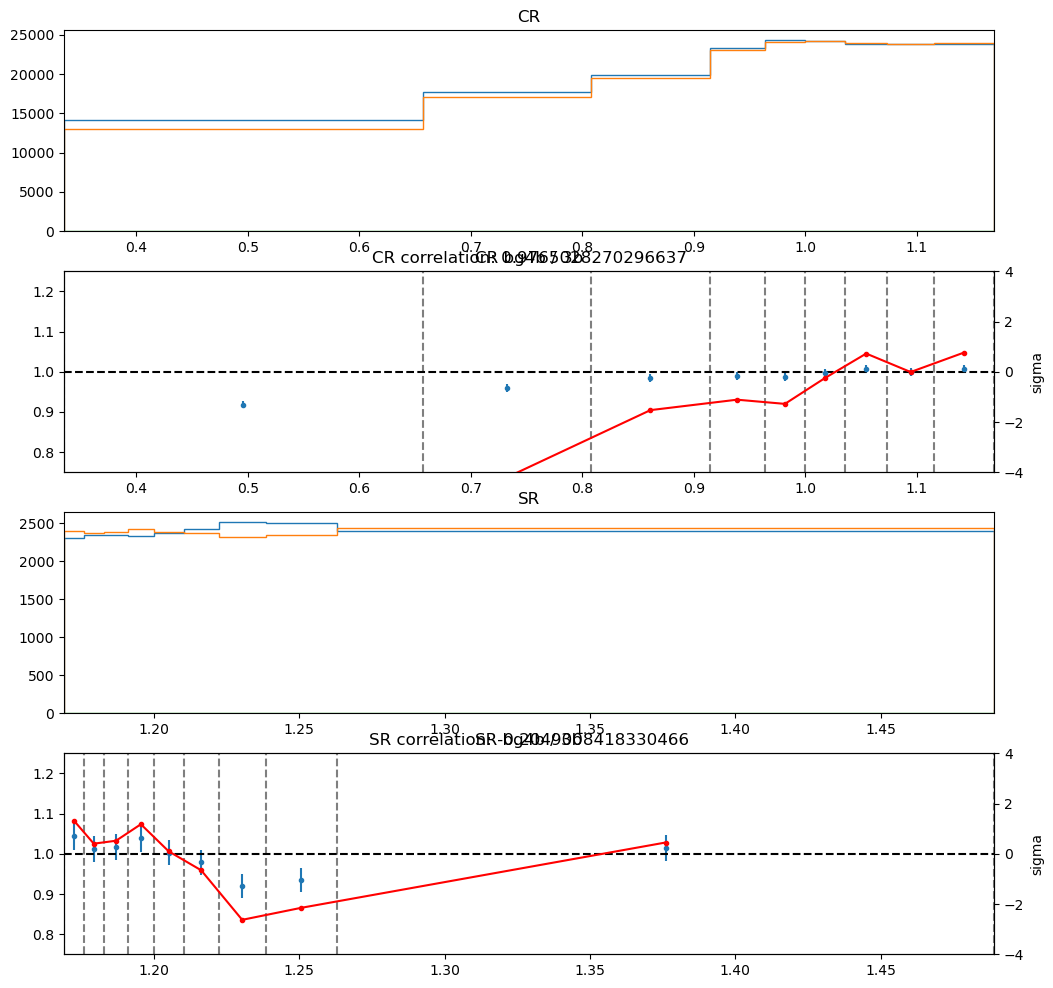

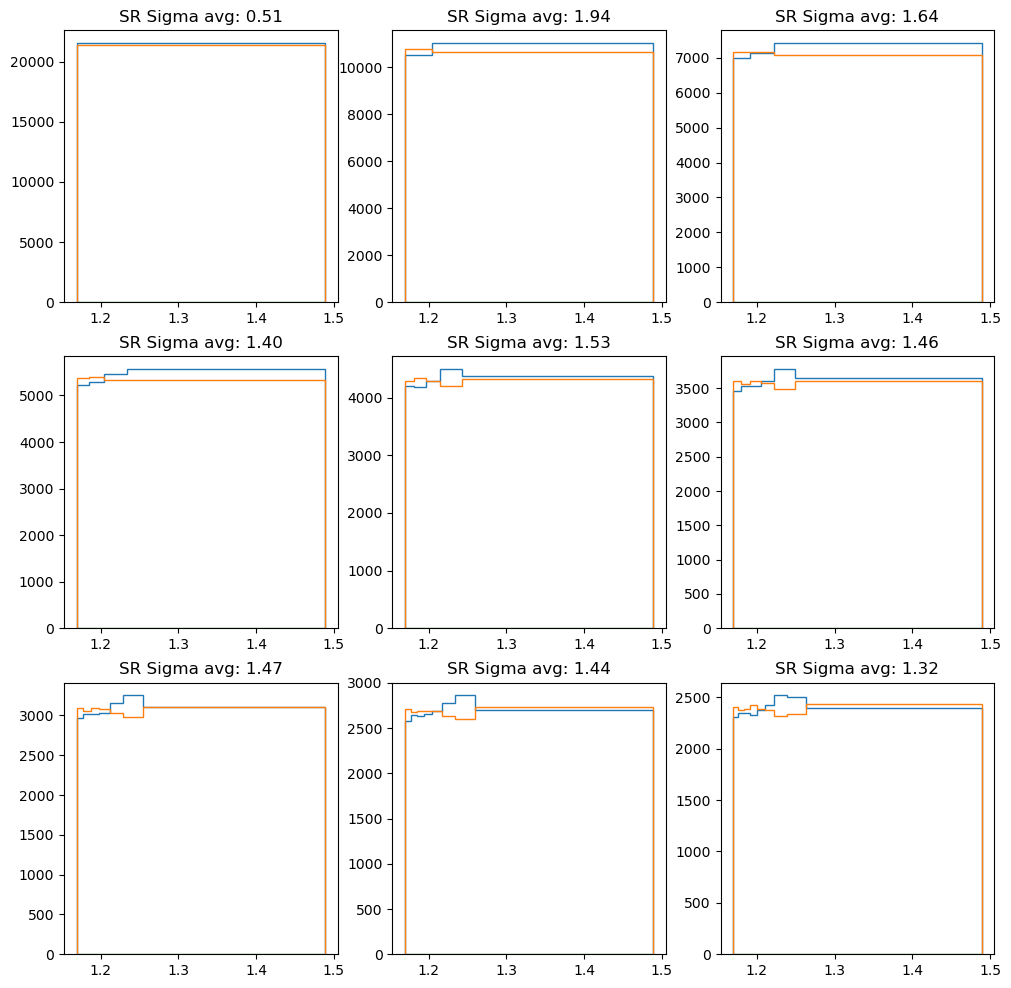

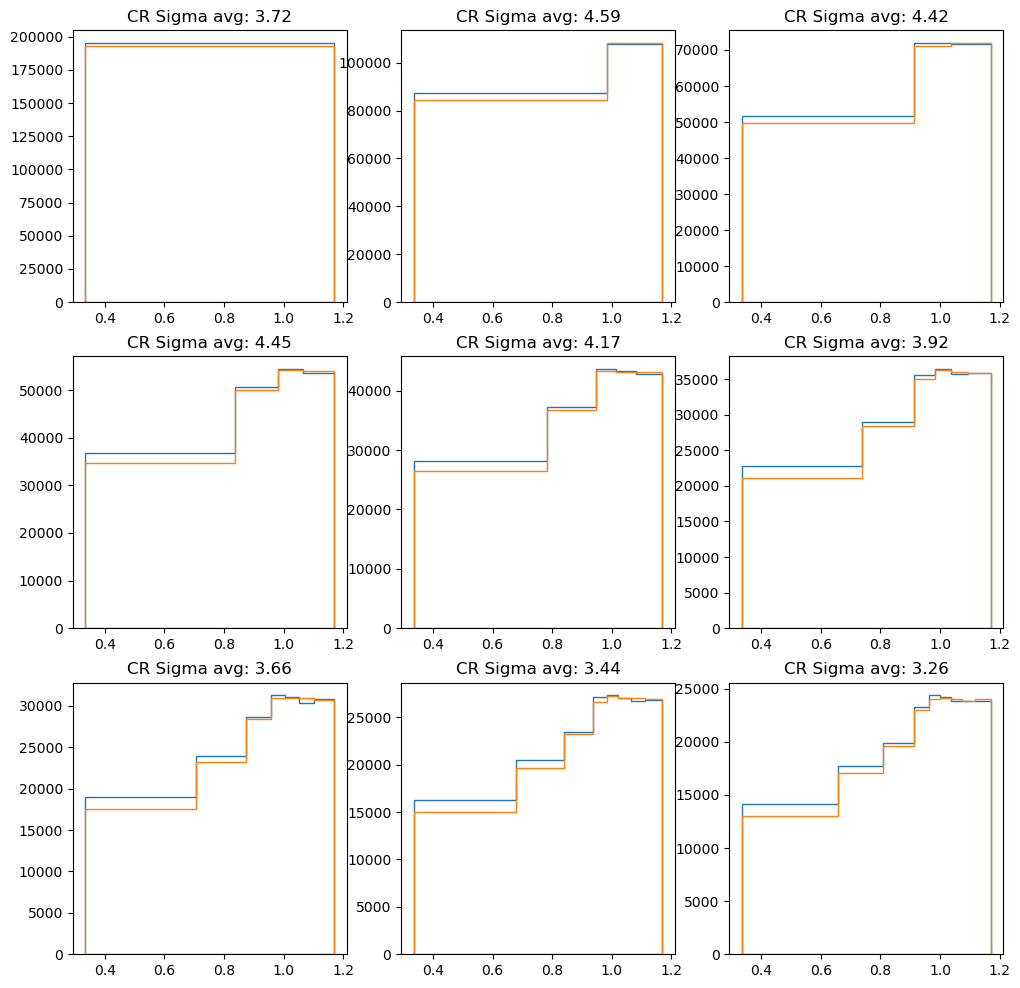

 17%|█▋        | 1/6 [00:17<01:28, 17.64s/it]

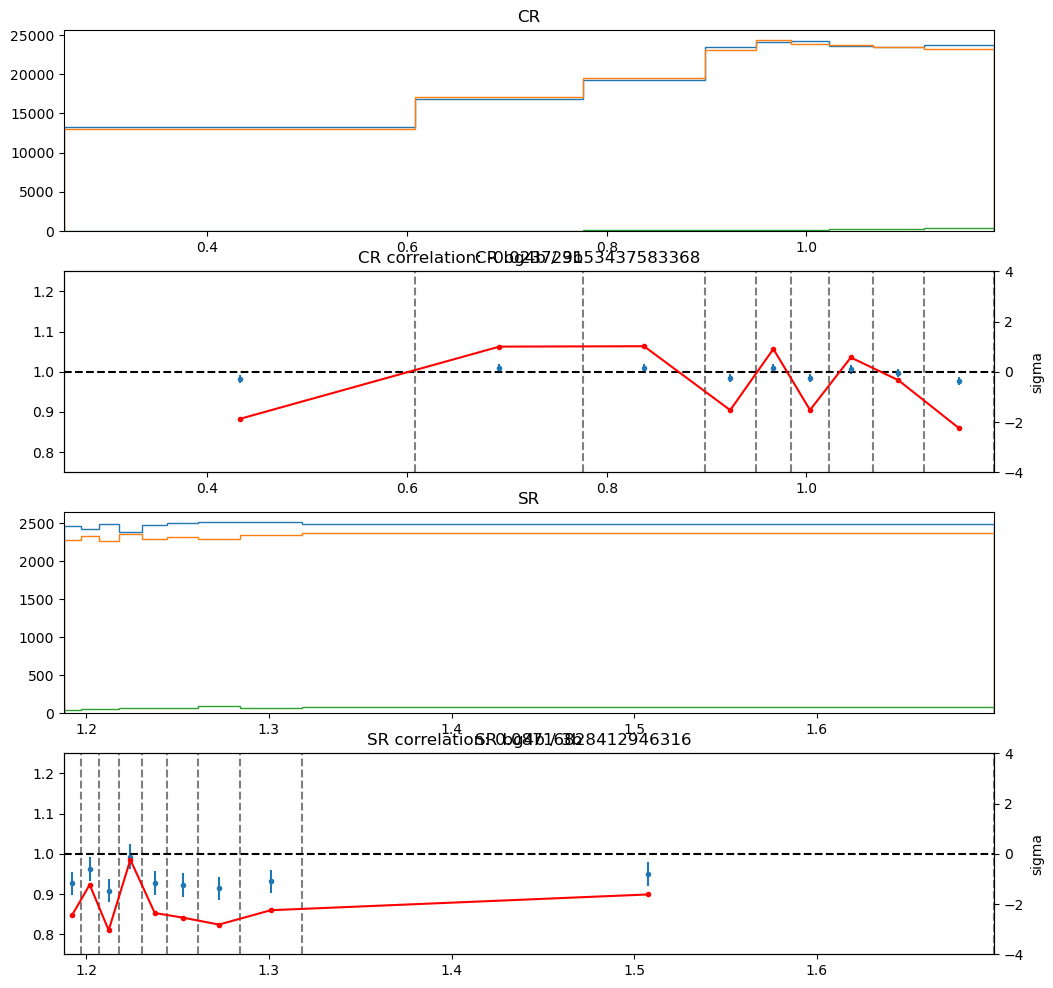

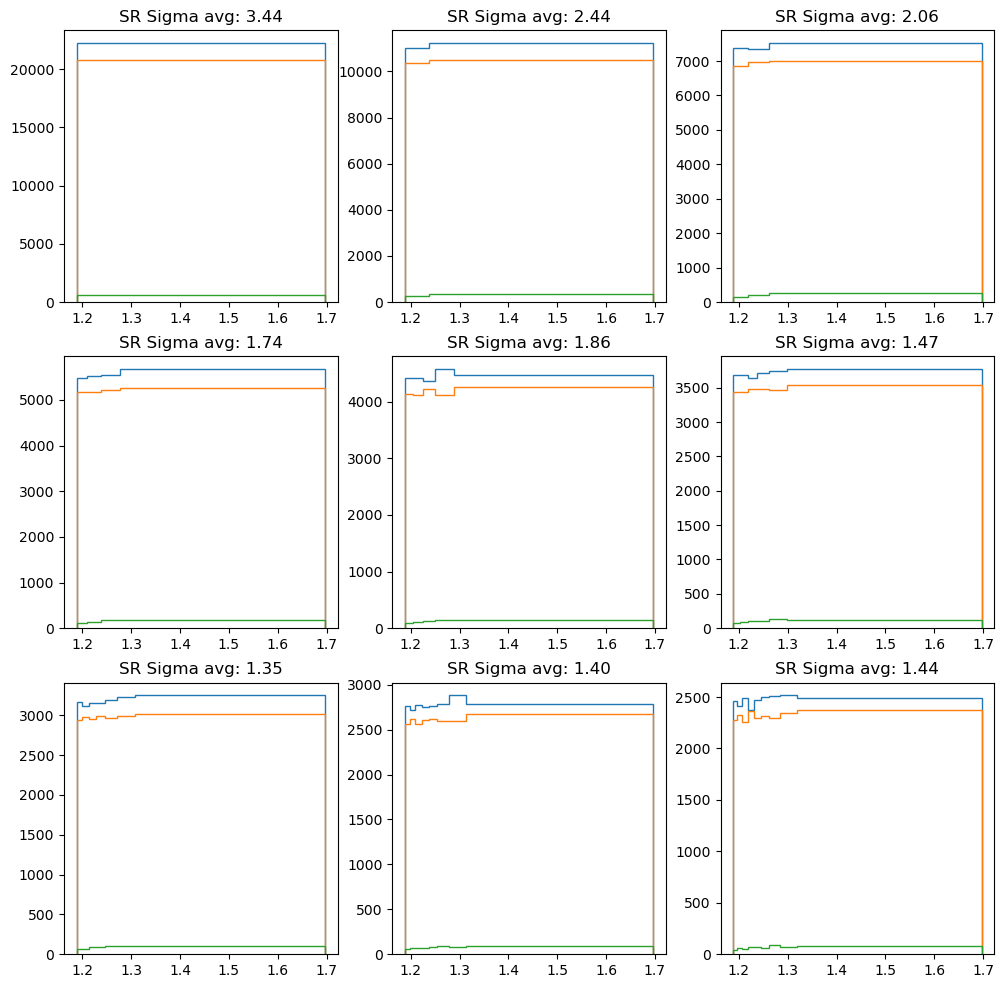

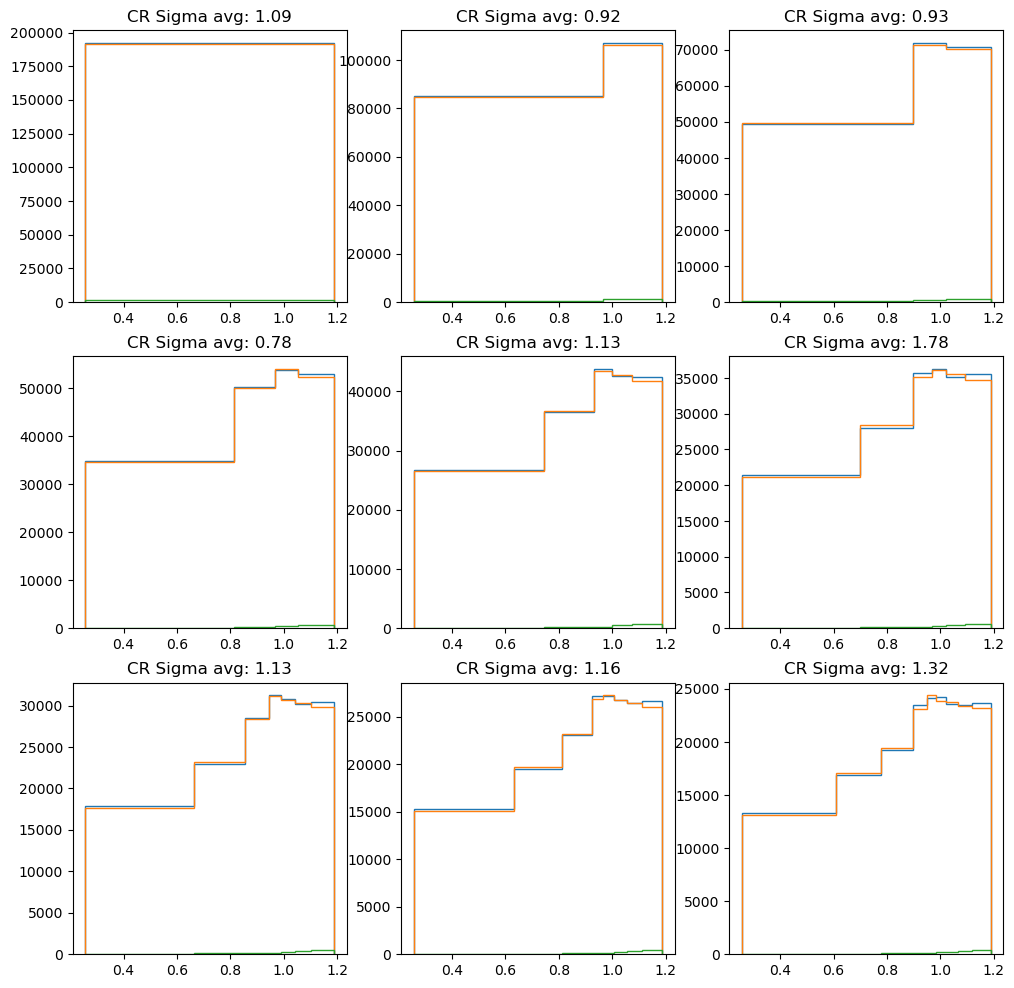

 33%|███▎      | 2/6 [00:40<01:20, 20.10s/it]


KeyboardInterrupt: 

In [9]:
verbose = False
show_plots = False
hparam_filter = {
    "experiment_name": lambda x: x in ["counting_test_high_4b_in_CR"]
}

hashes = TSTInfo.find(hparam_filter)
tst_results_summary = []

for tstinfo_hash in (pbar := tqdm.tqdm(hashes)):

    if tstinfo_hash in [r["hash"] for r in tst_results]:
        continue

    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        
    experiment_name = tstinfo.hparams["experiment_name"]
    
    initialize_with_fvt = True if experiment_name == "counting_test_v2" else False

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    
    base_fvt_hash = tstinfo.base_fvt_tinfo_hash
    fvt_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{base_fvt_hash}_best.ckpt")
    fvt_model.eval()
    
    events_tst.set_model_scores(fvt_model)
    CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
    CR_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{CR_fvt_hash}_best.ckpt")
    CR_model.eval()

    SR_stats = tstinfo.SR_stats
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    in_SR = SR_stats >= SR_cut
    in_CR = (SR_stats < SR_cut) & (SR_stats >= CR_cut)

    weights_4b = events_tst.weights * events_tst.is_4b
    weights_signal = events_tst.weights * events_tst.is_signal
    
    ratio_4b = tstinfo.hparams["ratio_4b"]
    probs_4b_est = fvt_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
    # probs_4b_est = fvt_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
    reweights = ratio_4b * probs_4b_est / ((1 - ratio_4b) * (1 - probs_4b_est))
    # events_tst.reweight(
    #     np.where(events_tst.is_4b, events_tst.weights, events_tst.weights * reweights))
    
    events_SR = events_tst[in_SR]
    events_CR = events_tst[in_CR]
    SR_stats_SR = SR_stats[in_SR]
    SR_stats_CR = SR_stats[in_CR]
    
    events_SR_rw = events_SR.clone()
    events_SR_rw.reweight(
        np.where(events_SR_rw.is_4b, events_SR_rw.weights, events_SR_rw.weights * reweights[in_SR]))
    events_CR_rw = events_CR.clone()
    events_CR_rw.reweight(
        np.where(events_CR_rw.is_4b, events_CR_rw.weights, events_CR_rw.weights * reweights[in_CR]))
    

    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(4, 1, figure=fig)

    # bins = np.linspace(np.min(SR_stats_CR), np.max(SR_stats_CR), 10)
    q = np.linspace(0, 1, 10)
    bins = np.quantile(SR_stats_CR, q)

    ax = fig.add_subplot(gs[0])
    hist_events_by_labels(events_CR_rw, SR_stats_CR, bins=bins, ax=ax)
    ax.set_xlim((bins[0], bins[-1]))
    ax.set_title("CR")

    hist_3b, _ = np.histogram(SR_stats_CR[events_CR_rw.is_3b], bins=bins, 
                                weights=events_CR_rw.weights[events_CR_rw.is_3b])
    hist_3b_sq, _ = np.histogram(SR_stats_CR[events_CR_rw.is_3b], bins=bins,
                                weights=(events_CR_rw.weights * reweights[in_CR])[events_CR_rw.is_3b])
    hist_bg4b, _ = np.histogram(SR_stats_CR[events_CR_rw.is_bg4b], bins=bins, 
                                weights=events_CR_rw.weights[events_CR_rw.is_bg4b])
    ax = fig.add_subplot(gs[1])
    midpoints = (bins[1:] + bins[:-1]) / 2
    err = np.sqrt(hist_bg4b / hist_3b**2 + hist_3b_sq * (hist_bg4b / hist_3b**2)**2)
    ax.errorbar(midpoints, hist_bg4b / hist_3b, yerr=err, label="bg4b / 3b", fmt="o", markersize=3)
    ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
    ax.set_xlim((bins[0], bins[-1]))
    ax.set_ylim((0.75, 1.25))
    ax.set_title("CR bg4b / 3b")
    ymin, ymax = ax.get_ylim()
    ax.vlines(bins, ymin, ymax, color="black", linestyle="--", alpha=0.5)

    ax2 = ax.twinx()
    sigma = (hist_bg4b - hist_3b) / np.sqrt(hist_bg4b + hist_3b_sq)
    ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
    ax2.set_ylim((-4, 4))
    ax2.set_ylabel("sigma")
    ax2.set_title("CR correlation: " + str(np.corrcoef(midpoints, sigma)[0, 1]))

    
    # bins = np.linspace(np.min(SR_stats_SR), np.max(SR_stats_SR), 10)
    q = np.linspace(0, 1, 10)
    bins = np.quantile(SR_stats_SR, q)

    ax = fig.add_subplot(gs[2])
    hist_events_by_labels(events_SR_rw, SR_stats_SR, bins=bins, ax=ax)
    ax.set_xlim((bins[0], bins[-1]))
    ax.set_title("SR")

    hist_3b, _ = np.histogram(SR_stats_SR[events_SR_rw.is_3b], bins=bins, 
                                weights=events_SR_rw.weights[events_SR_rw.is_3b])
    hist_3b_sq, _ = np.histogram(SR_stats_SR[events_SR_rw.is_3b], bins=bins, 
                                weights=(events_SR_rw.weights * reweights[in_SR])[events_SR_rw.is_3b])
    hist_bg4b, _ = np.histogram(SR_stats_SR[events_SR_rw.is_bg4b], bins=bins, 
                                weights=events_SR_rw.weights[events_SR_rw.is_bg4b])
    ax = fig.add_subplot(gs[3])
    midpoints = (bins[1:] + bins[:-1]) / 2
    err = np.sqrt(hist_bg4b / hist_3b**2 + hist_3b_sq * (hist_bg4b / hist_3b**2)**2)
    ax.errorbar(midpoints, hist_bg4b / hist_3b, yerr=err, label="bg4b / 3b", fmt="o", markersize=3)
    ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
    ax.set_xlim((bins[0], bins[-1]))
    ax.set_ylim((0.75, 1.25))
    ax.set_title("SR bg4b / 3b")
    ymin, ymax = ax.get_ylim()
    ax.vlines(bins, ymin, ymax, color="black", linestyle="--", alpha=0.5)

    ax2 = ax.twinx()
    sigma = (hist_bg4b - hist_3b) / np.sqrt(hist_bg4b + hist_3b_sq)
    ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
    ax2.set_ylim((-4, 4))
    ax2.set_ylabel("sigma")
    ax2.set_title("SR correlation: " + str(np.corrcoef(midpoints, sigma)[0, 1]))


    plt.show()
    
    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(3, 3, figure=fig)

    fig2 = plt.figure(figsize=(12, 12))
    gs2 = GridSpec(3, 3, figure=fig2)

    nbins_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

    for ax_cnt, nbin in enumerate(nbins_list):
        ax = fig.add_subplot(gs[ax_cnt])
        ax2 = fig2.add_subplot(gs2[ax_cnt])

        q = np.linspace(0, 1, nbin + 1)
        bins_SR = np.quantile(SR_stats_SR, q)
        bins_CR = np.quantile(SR_stats_CR, q)

        # hist_events_by_labels(events_tst, SR_stats, bins_SR=bins_SR, ax=ax)
        hist_events_by_labels(events_SR_rw, SR_stats_SR, bins=bins_SR, ax=ax)
        hist_events_by_labels(events_CR_rw, SR_stats_CR, bins=bins_CR, ax=ax2)
        
        hist_info_SR = get_histogram_info(events_SR, SR_stats_SR, nbin, reweights=reweights[in_SR])
        hist_info_CR = get_histogram_info(events_CR, SR_stats_CR, nbin, reweights=reweights[in_CR])

        ax.set_title(f"SR Sigma avg: {hist_info_SR['sigma_avg']:.2f}")
        ax2.set_title(f"CR Sigma avg: {hist_info_CR['sigma_avg']:.2f}")

        # print("nbin: ", nbin,
        #       "sigma_avg_SR: ", hist_info_SR["sigma_avg"], 
        #       "sigma_avg_CR: ", hist_info_CR["sigma_avg"], 
        #       "last_sigma_SR: ", hist_info_SR["sigma"][-1],
        #         "last_sigma_CR: ", hist_info_CR["sigma"][-1],
        # )
        
        tst_results_summary.append({
            "signal_ratio": signal_ratio,
            "seed": seed,
            "nbin": nbin,
            "sigma_avg_SR": hist_info_SR["sigma_avg"],
            "sigma_avg_bg4b_SR": hist_info_SR["sigma_avg_bg4b"],
            "sigma_avg_CR": hist_info_CR["sigma_avg"],
            "sigma_avg_bg4b_CR": hist_info_CR["sigma_avg_bg4b"],
            "initialize_with_fvt": initialize_with_fvt,
            "df_SR": hist_info_SR["df"],
            "df_CR": hist_info_CR["df"],
            "reweight": "base"
        })
        
    plt.show()
# tst_results_summary_df = pd.DataFrame(tst_results_summary)    